# ANALYZING REAL BANK DATASET

# ANALYSIS

In [3]:
setwd("C:/Users/syara/Documents")

In [2]:
# Load required libraries
library(tidyverse)  # includes dplyr, ggplot2, and other useful packages
library(readxl)     # for reading Excel files
library(scales)     # for formatting plots
library(gridExtra)  # for arranging multiple plots
library(writexl)
library(dplyr)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




In [5]:
# Step 1: Data Loading and Cleaning
# Read Excel files
df_customer <- read_excel("Customer_Information_2025_English.xlsx")
df_expenditure <- read_excel("Expenditure_Information_2025_English.xlsx")

# Clean up the expense period (capitalize + strip spaces)
df_expenditure$`Statement Period` <- str_to_title(trimws(df_expenditure$`Statement Period`))

# Standardize the expense type (lowercase + strip spaces)
df_expenditure$`Expenditure Type` <- tolower(trimws(df_expenditure$`Expenditure Type`))

# Convert expense amounts to numeric (safe against corrupted data)
df_expenditure$`Expenditure Amount` <- as.numeric(df_expenditure$`Expenditure Amount`)
df_expenditure$`Expenditure Amount`[is.na(df_expenditure$`Expenditure Amount`)] <- 0

# Normalize all column names to remove spaces (as a precaution)
names(df_customer) <- trimws(names(df_customer))
names(df_expenditure) <- trimws(names(df_expenditure))

In [6]:
# Display first few rows of customer data
print(head(df_customer))

# Display first few rows of expenditure data
print(head(df_expenditure))

# A tibble: 6 × 12
  `IAB (Customer No)` `Year of Birth` `Monthly Income` `Educational Status`
                <dbl>           <dbl>            <dbl> <chr>               
1              100000            1990            28500 Below High School   
2              100001            1953            29500 Undergraduate       
3              100002            1999            31000 High School         
4              100003            1959           185000 Postgraduate        
5              100004            1962            32000 High School         
6              100005            1941            29500 Below High School   
# ℹ 8 more variables: `Marital Status` <chr>, Gender <chr>,
#   `Employment Status` <chr>, `Owns a House?` <dbl>, `Owns a Car?` <dbl>,
#   `Is İşcep Installed?` <dbl>, `Has SMS Communication Permission?` <dbl>,
#   `Has E-mail Communication Permission?` <dbl>
# A tibble: 6 × 5
  `IAB (Customer No)` `KKR No.`           `Statement Period` `Expenditure Type`
               

In [7]:
# Basic data summary
summary(df_customer)
summary(df_expenditure)

 IAB (Customer No) Year of Birth  Monthly Income   Educational Status
 Min.   :100000    Min.   :1939   Min.   : 24500   Length:3000       
 1st Qu.:100750    1st Qu.:1955   1st Qu.: 29500   Class :character  
 Median :101500    Median :1971   Median : 65000   Mode  :character  
 Mean   :101500    Mean   :1971   Mean   :106150                     
 3rd Qu.:102249    3rd Qu.:1987   3rd Qu.:175000                     
 Max.   :102999    Max.   :2004   Max.   :345000                     
 Marital Status        Gender          Employment Status  Owns a House?  
 Length:3000        Length:3000        Length:3000        Min.   :0.000  
 Class :character   Class :character   Class :character   1st Qu.:0.000  
 Mode  :character   Mode  :character   Mode  :character   Median :0.000  
                                                          Mean   :0.493  
                                                          3rd Qu.:1.000  
                                                          Max.   :

 IAB (Customer No)   KKR No.          Statement Period   Expenditure Type  
 Min.   :100000    Length:126000      Length:126000      Length:126000     
 1st Qu.:100750    Class :character   Class :character   Class :character  
 Median :101500    Mode  :character   Mode  :character   Mode  :character  
 Mean   :101500                                                            
 3rd Qu.:102249                                                            
 Max.   :102999                                                            
 Expenditure Amount
 Min.   :    0     
 1st Qu.:    0     
 Median :    0     
 Mean   : 2870     
 3rd Qu.: 4696     
 Max.   :15000     

In [10]:
# Step 2: Identifying Categorical Variable Values

# Education Status
print("Educational Status:")
df_customer %>% 
  distinct(`Educational Status`) %>%
  pull()

# Employment Status
print("Employment Status:")
df_customer %>% 
  distinct(`Employment Status`) %>%
  pull()

# Statement Period
print("Statement Period:")
df_expenditure %>% 
  distinct(`Statement Period`) %>%
  pull()

# Expenditure Type
print("Expenditure Type:")
df_expenditure %>% 
  distinct(`Expenditure Type`) %>%
  pull()

[1] "Educational Status:"


[1] "Below High School" "Undergraduate"     "High School"      
[4] "Postgraduate"

[1] "Employment Status:"


[1] "Freelance"     "Civil Servant" "Worker"        "Retired"

[1] "Statement Period:"


[1] "June"   "July"   "August"

[1] "Expenditure Type:"


[1] "electronics"     "market"          "other"           "clothing"       
 [5] "tourism"         "automotive"      "cosmetics"       "cash withdrawal"
 [9] "education"       "furniture"       "travel"          "white goods"    
[13] "fuel"            "tax payments"

In [11]:
# Step 3: Create and Summarize Spend Groups Based on Customers

# Create a function to group expenditure types
expenditure_group <- function(tur) {
  tur <- tolower(trimws(as.character(tur)))
  if (grepl("market", tur)) {
    return("market")
  } else if (grepl("fuel", tur)) {
    return("fuel")
  } else {
    return("other")
  }
}

# Apply the function to create new column
df_expenditure$`Expenditure Group` <- sapply(df_expenditure$`Expenditure Type`, expenditure_group)

# Calculate the number of months spent for each customer
month_numbers <- df_expenditure %>%
  group_by(`IAB (Customer No)`) %>%
  summarise(Month_Number = n_distinct(`Statement Period`))

# Calculate the total amount of each spending group based on the customer
df_expenditure_summary <- df_expenditure %>%
  group_by(`IAB (Customer No)`, `Expenditure Group`) %>%
  summarise(Total_Amount = sum(`Expenditure Amount`), .groups = "drop") %>%
  pivot_wider(
    names_from = `Expenditure Group`,
    values_from = Total_Amount,
    values_fill = 0
  )

# Add possible missing groups (as columns)
required_groups <- c("market", "fuel", "other")
missing_groups <- setdiff(required_groups, names(df_expenditure_summary))
for (group in missing_groups) {
  df_expenditure_summary[[group]] <- 0
}

# Merge with the number of months
df_expenditure_summary <- left_join(df_expenditure_summary, month_numbers, by = "IAB (Customer No)")

# Calculate averages
df_expenditure_summary <- df_expenditure_summary %>%
  mutate(
    market = market / Month_Number,
    fuel = fuel / Month_Number,
    other = other / Month_Number
  )

# Remove the Month_Number column
df_expenditure_summary <- df_expenditure_summary %>%
  select(-Month_Number)

# Export to Excel
writexl::write_xlsx(df_expenditure_summary, "df_expenditure_summary_monthly.xlsx")

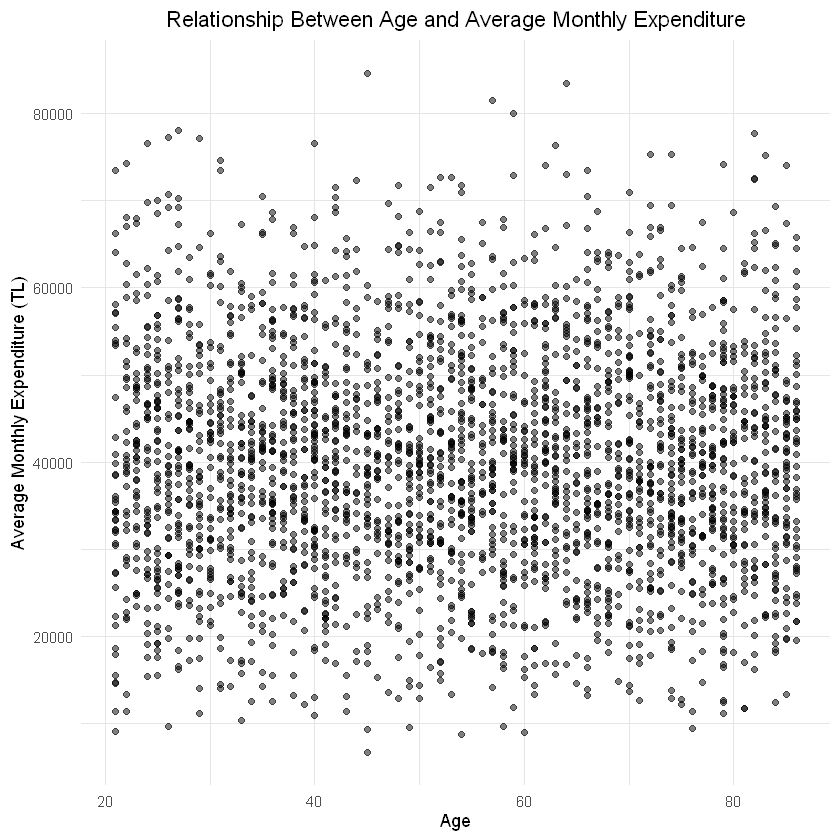

In [12]:
# Step 4: Start Data Visualization and Storytelling

# Step 4.1: Merge Customer and Expenditure Summary Data
df_customer <- read_excel("Customer_Information_2025_English.xlsx")
df_expenditure_summary <- read_excel("df_expenditure_summary_monthly.xlsx")

# Merge the dataframes
df <- left_join(df_customer, df_expenditure_summary, by = "IAB (Customer No)") %>%
  replace_na(list(market = 0, fuel = 0, other = 0))

# Step 4.2: Calculate Age and Total Expenditure Variables
df <- df %>%
  mutate(
    Age = 2025 - `Year of Birth`,
    `Total Expenditure` = market + fuel + other
  )

# Step 4.3: Age vs. Total Expenditure – Scatter Diagram
ggplot(df, aes(x = Age, y = `Total Expenditure`)) +
  geom_point(alpha = 0.5) +
  theme_minimal() +
  labs(
    title = "Relationship Between Age and Average Monthly Expenditure",
    x = "Age",
    y = "Average Monthly Expenditure (TL)"
  ) +
  theme(
    plot.title = element_text(hjust = 0.5),
    panel.grid = element_line(color = "gray90")
  )

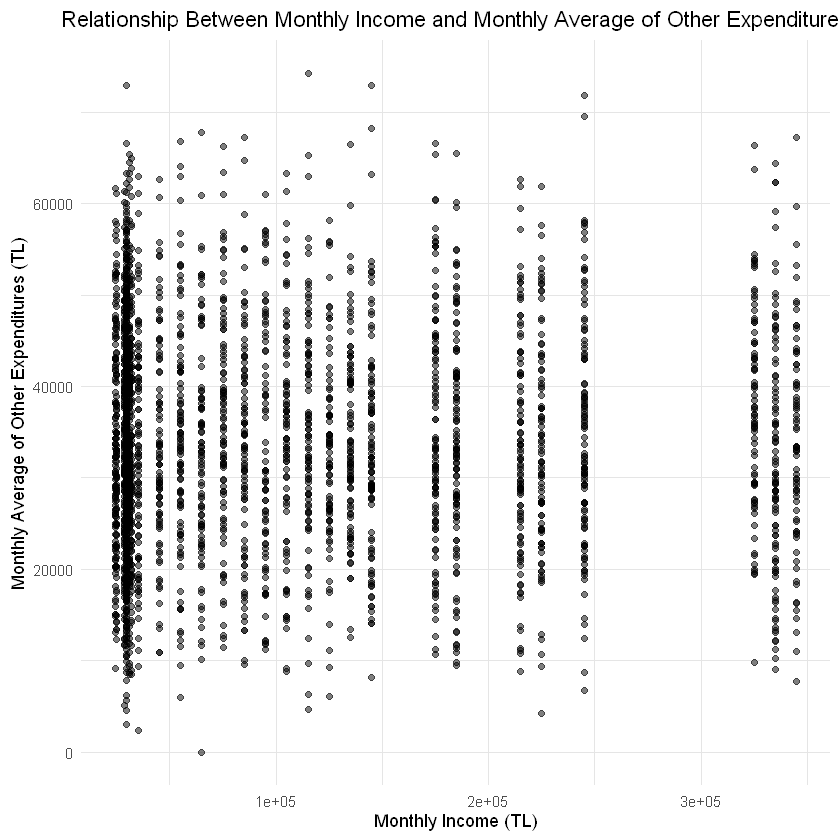

In [14]:
# Step 4.4: Monthly Income vs. Monthly Average Other Expenditures – Scatter Diagram
ggplot(df, aes(x = `Monthly Income`, y = other)) +
  geom_point(alpha = 0.5) +
  theme_minimal() +
  labs(
    title = "Relationship Between Monthly Income and Monthly Average of Other Expenditures",
    x = "Monthly Income (TL)",
    y = "Monthly Average of Other Expenditures (TL)"
  ) +
  theme(
    plot.title = element_text(hjust = 0.5),
    panel.grid = element_line(color = "gray90")
  )

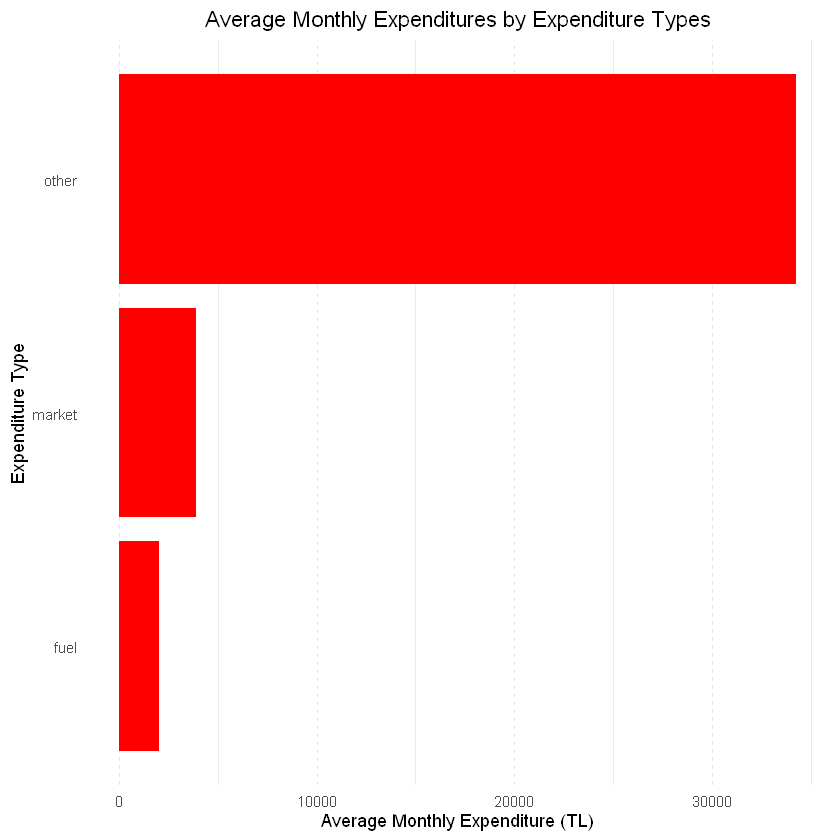

In [15]:
# Step 4.5: Monthly Average Expenditure by Expenditure Types – Horizontal Bar Graph

# Calculate means and create a data frame
expenditure_means <- df %>%
  summarise(
    market = mean(market),
    fuel = mean(fuel),
    other = mean(other)
  ) %>%
  pivot_longer(
    cols = everything(),
    names_to = "Expenditure_Type",
    values_to = "Mean_Expenditure"
  ) %>%
  arrange(Mean_Expenditure)

# Create horizontal bar plot
ggplot(expenditure_means, aes(x = reorder(Expenditure_Type, Mean_Expenditure), y = Mean_Expenditure)) +
  geom_bar(stat = "identity", fill = "red") +
  coord_flip() +  # This makes the bar plot horizontal
  theme_minimal() +
  labs(
    title = "Average Monthly Expenditures by Expenditure Types",
    x = "Expenditure Type",
    y = "Average Monthly Expenditure (TL)"
  ) +
  theme(
    plot.title = element_text(hjust = 0.5),
    panel.grid.major.x = element_line(color = "gray90", linetype = "dashed"),
    panel.grid.major.y = element_blank()
  )

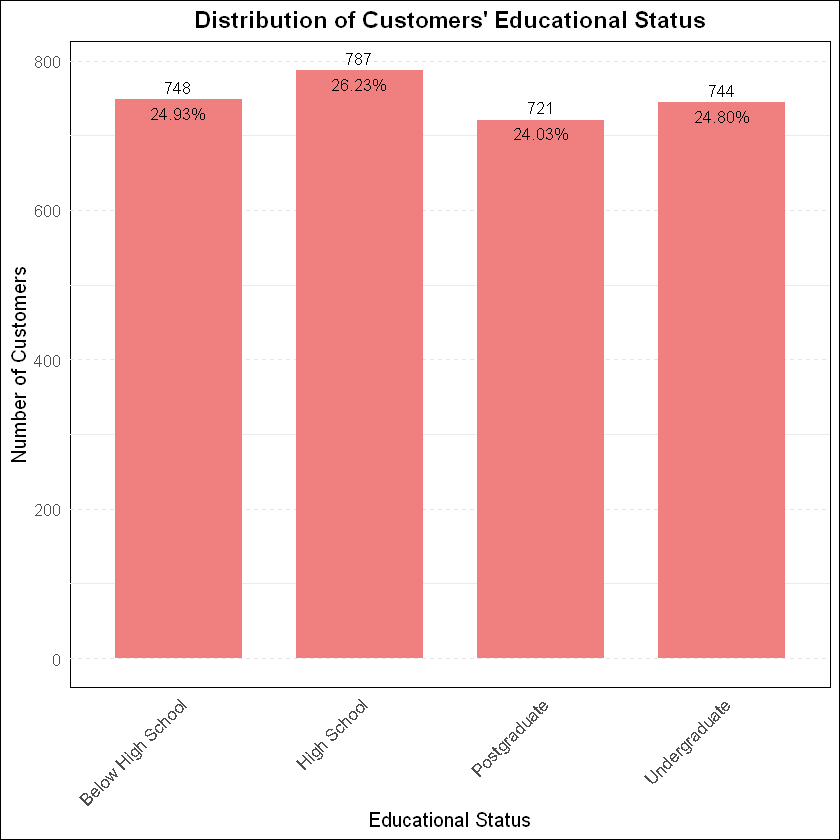

In [19]:
# Step 5 – Customer Distributions According to Categorical Variables
# 5.1 – Distribution of Educational Status (Bar Chart)
ggplot(df_customer, aes(x = `Educational Status`)) +
  geom_bar(fill = "lightcoral", width = 0.7) +
  geom_text(
    aes(label = ..count..),  # Add count labels
    stat = "count",
    vjust = -0.5,  # Position labels above bars
    size = 3.5
  ) +
  theme_minimal() +
  labs(
    title = "Distribution of Customers' Educational Status",
    x = "Educational Status",
    y = "Number of Customers"
  ) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10),
    panel.grid.major.y = element_line(color = "gray90", linetype = "dashed"),
    panel.grid.major.x = element_blank(),
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.background = element_rect(fill = "white"),
    panel.background = element_rect(fill = "white")
  ) +
  # Add percentage labels
  geom_text(
    aes(label = scales::percent(..count../sum(..count..))),
    stat = "count",
    vjust = 1.5,
    size = 3.5
  )

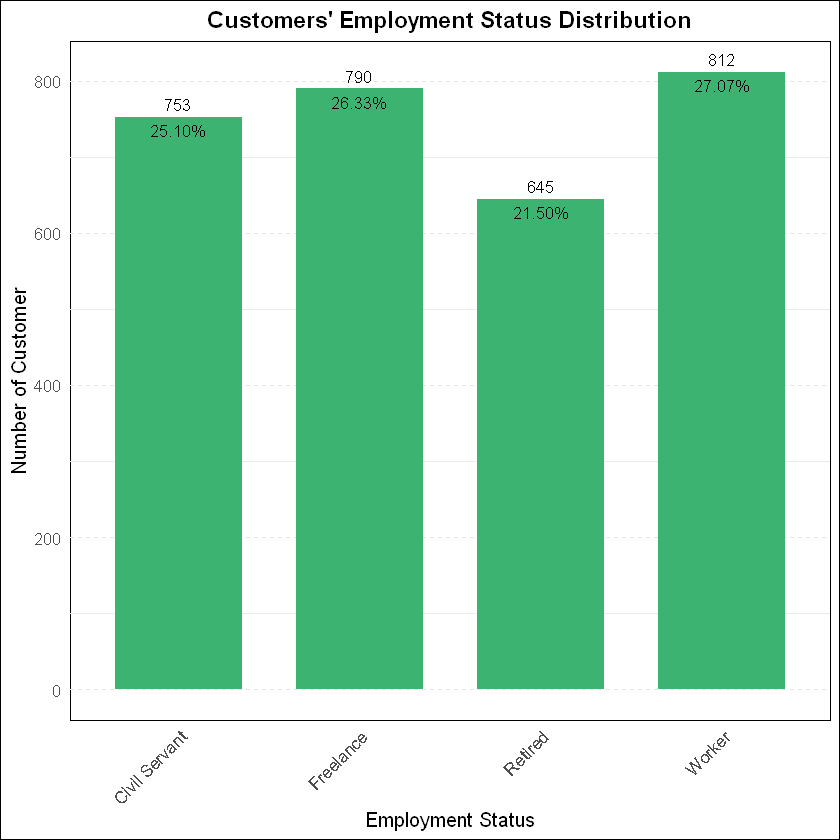

In [18]:
# 5.2 – Employment Status Distribution (Bar Chart)
ggplot(df_customer, aes(x = `Employment Status`)) +
  geom_bar(fill = "mediumseagreen", width = 0.7) +
  geom_text(
    aes(label = ..count..),  # Add count labels
    stat = "count",
    vjust = -0.5,  # Position labels above bars
    size = 3.5
  ) +
  theme_minimal() +
  labs(
    title = "Customers' Employment Status Distribution",
    x = "Employment Status",
    y = "Number of Customer"
  ) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10),
    panel.grid.major.y = element_line(color = "gray90", linetype = "dashed"),
    panel.grid.major.x = element_blank(),
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.background = element_rect(fill = "white"),
    panel.background = element_rect(fill = "white")
  ) +
  # Add percentage labels
  geom_text(
    aes(label = scales::percent(..count../sum(..count..))),
    stat = "count",
    vjust = 1.5,
    size = 3.5
  )

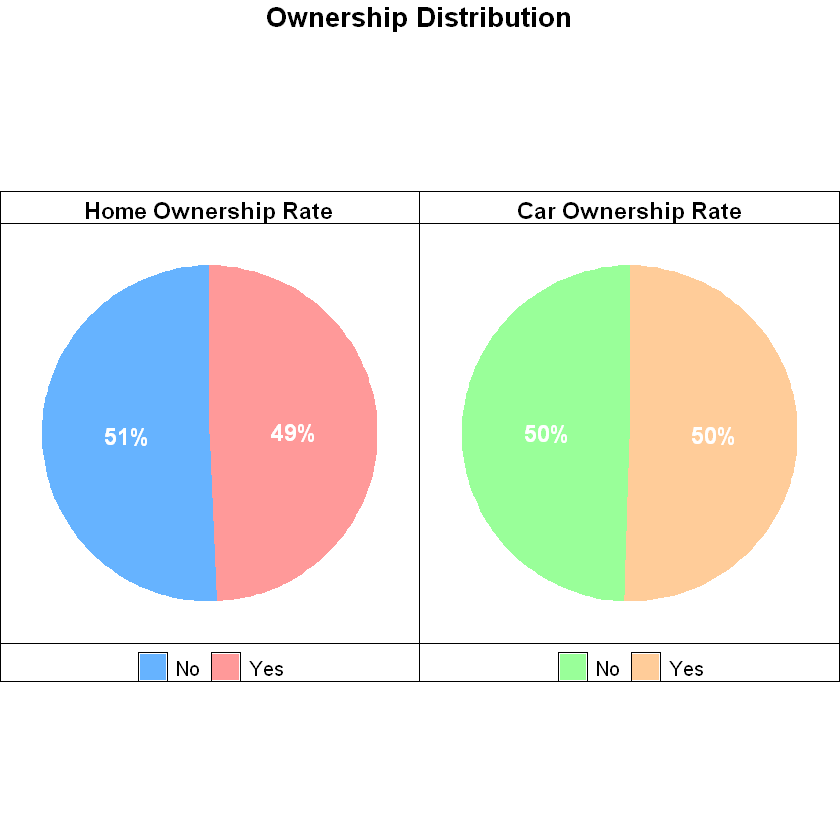

In [21]:
# 5.3 – Home and Car Ownership Rates (Pie Chart)

# Load required packages
library(ggplot2)
library(dplyr)
library(gridExtra)
library(grid)  # Add this for textGrob

# Create a function to make pie charts with more customization
create_pie_chart_custom <- function(data, column, title, colors) {
  # Calculate percentages
  pie_data <- data %>%
    count(!!sym(column)) %>%
    mutate(
      percentage = n / sum(n) * 100,
      label = paste0(round(percentage), "%"),
      category = ifelse(!!sym(column) == 1, "Yes", "No")
    )
  
  # Create pie chart
  ggplot(pie_data, aes(x = "", y = n, fill = category)) +
    geom_bar(stat = "identity", width = 1) +
    coord_polar("y", start = 0) +
    theme_void() +
    scale_fill_manual(values = colors) +
    labs(title = title) +
    theme(
      plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
      legend.title = element_blank(),
      legend.position = "bottom",
      legend.text = element_text(size = 12),
      plot.background = element_rect(fill = "white"),
      panel.background = element_rect(fill = "white")
    ) +
    geom_text(
      aes(label = label),
      position = position_stack(vjust = 0.5),
      color = "white",
      size = 5,
      fontface = "bold"
    )
}

# Create the two pie charts
p1 <- create_pie_chart_custom(
  df_customer, 
  "Owns a House?", 
  "Home Ownership Rate",
  c("#66b3ff", "#ff9999")
)

p2 <- create_pie_chart_custom(
  df_customer, 
  "Owns a Car?", 
  "Car Ownership Rate",
  c("#99ff99", "#ffcc99")
)

# Arrange the plots side by side with a title
grid.arrange(
  p1, p2, 
  ncol = 2,
  top = textGrob("Ownership Distribution", gp = gpar(fontsize = 16, fontface = "bold"))
)

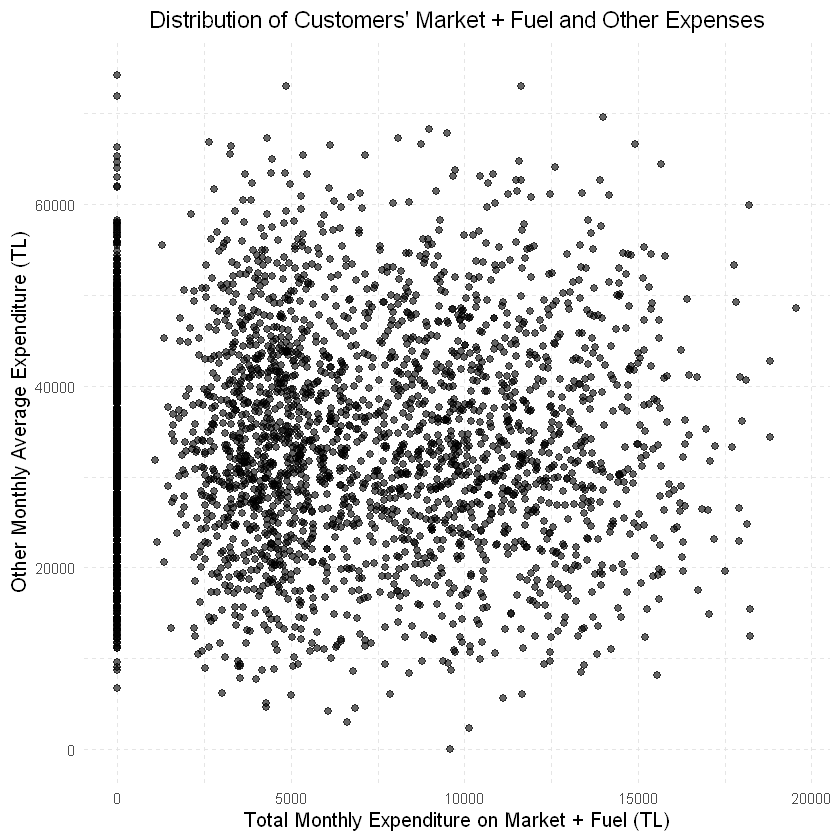

In [23]:
# Step 6 – Scatter Diagram by Customer Based on Expenditure Types

# Read the data
df_campaign <- read_excel("df_expenditure_summary_monthly.xlsx")

# Calculate Market + Fuel Expenditures Total
df_campaign <- df_campaign %>%
  mutate(market_fuel_total = market + fuel)

# Create scatter plot
ggplot(df_campaign, aes(x = market_fuel_total, y = other)) +
  geom_point(
    alpha = 0.6,
    color = "black",
    size = 2,
    stroke = 0.3
  ) +
  theme_minimal() +
  labs(
    title = "Distribution of Customers' Market + Fuel and Other Expenses",
    x = "Total Monthly Expenditure on Market + Fuel (TL)",
    y = "Other Monthly Average Expenditure (TL)"
  ) +
  theme(
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title = element_text(size = 12),
    panel.grid = element_line(color = "gray90", linetype = "dashed")
  )

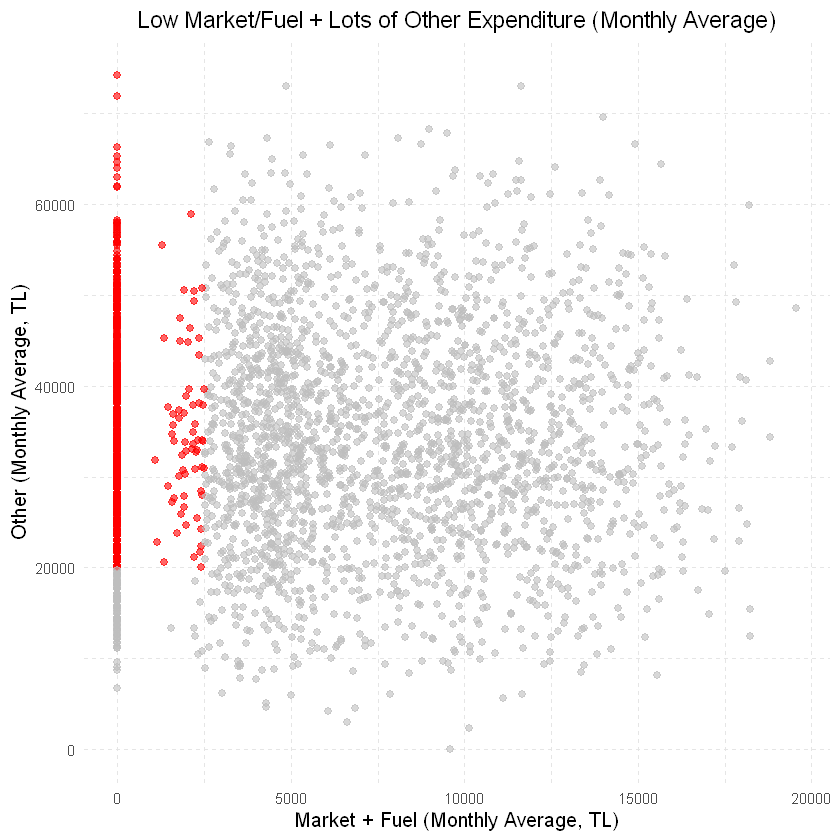

In [27]:
# Step 7 – Scatter Diagram Highlighting Low Market/Fuel + High Other Spenders

# Read the data if not already loaded
df_campaign <- read_excel("df_expenditure_summary_monthly.xlsx")

# Calculate monthly averages and create target customer flag
df_campaign <- df_campaign %>%
  mutate(
    market_fuel_monthly = market + fuel,
    other_monthly = other,
    target_customer = ifelse(market_fuel_monthly < 2500 & other_monthly > 20000, 1, 0)
  )

# Create scatter plot
ggplot(df_campaign, aes(x = market_fuel_monthly, y = other_monthly, color = factor(target_customer))) +
  geom_point(
    alpha = 0.6,
    size = 2,
    stroke = 0.3
  ) +
  scale_color_manual(
    values = c("0" = "gray", "1" = "red"),  # Changed 'crimson' to 'red'
    labels = c("Other Customers", "TARGET customers")
  ) +
  theme_minimal() +
  labs(
    title = "Low Market/Fuel + Lots of Other Expenditure (Monthly Average)",
    x = "Market + Fuel (Monthly Average, TL)",
    y = "Other (Monthly Average, TL)",
    color = ""  # Remove legend title
  ) +
  theme(
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title = element_text(size = 12),
    panel.grid = element_line(color = "gray90", linetype = "dashed"),
    legend.position = "top right"
  )

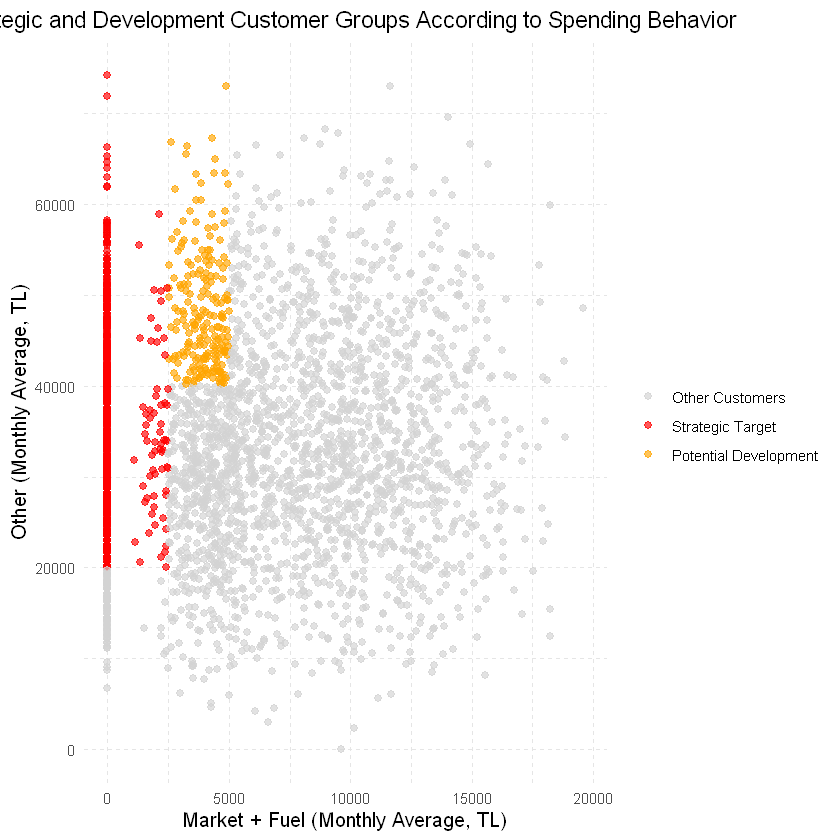

In [28]:
# Step 8 – Two-Level Target Customer Emphasis: "Strategic Target" and "Potential Development"

# Read the data if not already loaded
df_campaign <- read_excel("df_expenditure_summary_monthly.xlsx")

# Calculate monthly totals
df_campaign <- df_campaign %>%
  mutate(
    market_fuel_monthly = market + fuel,
    other_monthly = other,
    # Create segment categories
    segment_category = case_when(
      market_fuel_monthly < 2500 & other_monthly > 20000 ~ 1,  # Strategic Target
      market_fuel_monthly < 5000 & other_monthly > 40000 ~ 2,  # Potential Development
      TRUE ~ 0  # Other
    )
  )

# Create the plot
ggplot(df_campaign, aes(x = market_fuel_monthly, y = other_monthly, color = factor(segment_category))) +
  geom_point(
    alpha = 0.65,
    size = 2,
    stroke = 0.3
  ) +
  scale_color_manual(
    values = c("0" = "lightgray", "1" = "red", "2" = "orange"),
    labels = c("Other Customers", "Strategic Target", "Potential Development")
  ) +
  theme_minimal() +
  labs(
    title = "Strategic and Development Customer Groups According to Spending Behavior",
    x = "Market + Fuel (Monthly Average, TL)",
    y = "Other (Monthly Average, TL)",
    color = ""
  ) +
  theme(
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title = element_text(size = 12),
    panel.grid = element_line(color = "gray90", linetype = "dashed"),
    legend.position = "right"
  )

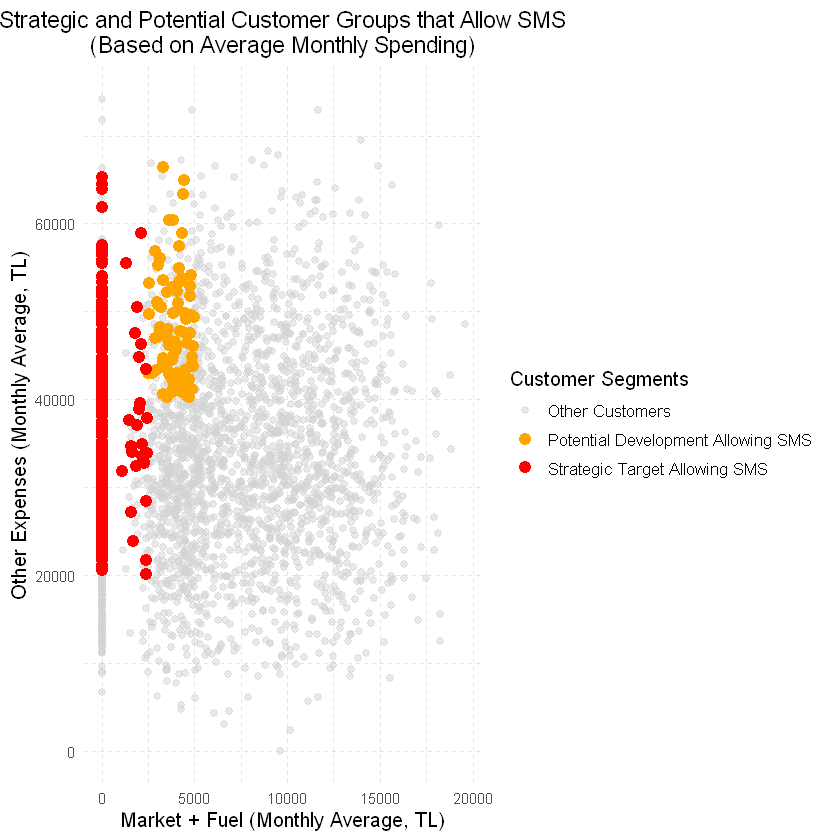

In [3]:
# Step 9 – Scatter Plot Highlighting Strategic and Potential Groups with SMS Permission

# 1. Read Excel files
df_customer <- read_excel("Customer_Information_2025_English.xlsx")
df_expenditure_monthly <- read_excel("df_expenditure_summary_monthly.xlsx")

# 2. Merge → campaign dataset (simplified join)
df_campaign <- left_join(
  df_customer,
  df_expenditure_monthly,
  by = "IAB (Customer No)"  # Only join on customer ID
) %>%
  replace_na(list(market = 0, fuel = 0, other = 0))

# 3. New variables: Market + Fuel and Other expenses total (monthly average)
df_campaign <- df_campaign %>%
  mutate(
    market_fuel_monthly = market + fuel,
    other_monthly = other,
    # 4. Segmentation
    segment_category = case_when(
      market_fuel_monthly < 2500 & other_monthly > 20000 ~ 1,  # Strategic Target
      market_fuel_monthly < 5000 & other_monthly > 40000 ~ 2,  # Potential Development
      TRUE ~ 0  # Other
    )
  )

# 5. Create subsets for different groups
strategic_sms <- df_campaign %>%
  filter(segment_category == 1 & `Has SMS Communication Permission?` == 1)

potential_sms <- df_campaign %>%
  filter(segment_category == 2 & `Has SMS Communication Permission?` == 1)

other <- df_campaign %>%
  anti_join(strategic_sms, by = "IAB (Customer No)") %>%
  anti_join(potential_sms, by = "IAB (Customer No)")

# 6. Create scatter plot with legend
ggplot() +
  # Other customers
  geom_point(
    data = other,
    aes(x = market_fuel_monthly, y = other_monthly, color = "Other Customers"),
    alpha = 0.5,
    size = 2,
    stroke = 0.2
  ) +
  # Potential Development with SMS
  geom_point(
    data = potential_sms,
    aes(x = market_fuel_monthly, y = other_monthly, color = "Potential Development Allowing SMS"),
    size = 3,
    stroke = 0.5
  ) +
  # Strategic Target with SMS
  geom_point(
    data = strategic_sms,
    aes(x = market_fuel_monthly, y = other_monthly, color = "Strategic Target Allowing SMS"),
    size = 3,
    stroke = 0.5
  ) +
  theme_minimal() +
  labs(
    title = "Strategic and Potential Customer Groups that Allow SMS\n(Based on Average Monthly Spending)",
    x = "Market + Fuel (Monthly Average, TL)",
    y = "Other Expenses (Monthly Average, TL)",
    color = "Customer Segments"  # Legend title
  ) +
  theme(
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title = element_text(size = 12),
    panel.grid = element_line(color = "gray90", linetype = "dashed"),
    legend.position = "right",
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 10)
  ) +
  # Add legend with custom colors
  scale_color_manual(
    values = c(
      "Other Customers" = "lightgray",
      "Potential Development Allowing SMS" = "orange",
      "Strategic Target Allowing SMS" = "red"
    )
  )

In [33]:
# Step 10: Segmentation of Strategic and Potential Customer Groups that Allow SMS and Transfer to Excel

# 1. Load Data
df_customer <- read_excel("Customer_Information_2025_English.xlsx")
df_expenditure_monthly <- read_excel("df_expenditure_summary_monthly.xlsx")

# Merge datasets
df_campaign <- left_join(
  df_customer,
  df_expenditure_monthly,
  by = "IAB (Customer No)"
) %>%
  replace_na(list(market = 0, fuel = 0, other = 0))

# 2. Calculate expenditure totals
df_campaign <- df_campaign %>%
  mutate(
    market_fuel_monthly = market + fuel,
    other_monthly = other
  )

# 3. Filter only those who permit SMS
df_sms <- df_campaign %>%
  filter(`Has SMS Communication Permission?` == 1)

# 4. Segment assignment
df_sms <- df_sms %>%
  mutate(
    Segment_Type = case_when(
      market_fuel_monthly < 2500 & other_monthly > 20000 ~ "Strategic Target",
      market_fuel_monthly < 5000 & other_monthly > 40000 ~ "Potential Development",
      TRUE ~ NA_character_  # Out of segment
    )
  )

# 5. Filter target groups (remove NA values)
df_export <- df_sms %>%
  filter(!is.na(Segment_Type))

# 6. Save to Excel
write_xlsx(df_export, "target_customer_list.xlsx")

In [34]:
# Step 11: Calculate Statistics by Segment

# 1. Read the file
df <- read_excel("target_customer_list.xlsx")

# 2. Select the relevant numeric variables
variables <- c(
    'market',
    'fuel',
    'other',
    'market_fuel_monthly',
    'other_monthly',
    'Monthly Income',
    'Year of Birth'
)

# 3. Calculate mean and std by segments
result <- df %>%
  group_by(Segment_Type) %>%
  summarise(
    across(
      all_of(variables),
      list(
        mean = ~mean(., na.rm = TRUE),
        std = ~sd(., na.rm = TRUE)
      )
    )
  )

# 4. Show the result (rounded to 2 decimal places)
result %>%
  mutate(across(where(is.numeric), ~round(., 2)))

Segment_Type,market_mean,market_std,fuel_mean,fuel_std,other_mean,other_std,market_fuel_monthly_mean,market_fuel_monthly_std,other_monthly_mean,other_monthly_std,Monthly Income_mean,Monthly Income_std,Year of Birth_mean,Year of Birth_std
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Potential Development,591.61,1458.65,3316.01,1509.82,47940.37,6104.23,3907.62,660.14,47940.37,6104.23,113500.0,101530.36,1972.96,20.18
Strategic Target,8.76,116.96,144.81,529.71,36910.76,9552.80,153.57,540.12,36910.76,9552.80,108034.3,94273.66,1969.08,18.41


In [35]:
# Step 12: Profiling for Numerical Variables
# Calculate Average and Standard Deviation

# Using the same variables from previous step
variables <- c(
    'market',
    'fuel',
    'other',
    'market_fuel_monthly',
    'other_monthly',
    'Monthly Income',
    'Year of Birth'
)

# Calculate mean and std by segments
df %>%
  group_by(Segment_Type) %>%
  summarise(
    across(
      all_of(variables),
      list(
        mean = ~mean(., na.rm = TRUE),
        std = ~sd(., na.rm = TRUE)
      )
    )
  ) %>%
  # Round all numeric columns to 2 decimal places
  mutate(across(where(is.numeric), ~round(., 2)))

Segment_Type,market_mean,market_std,fuel_mean,fuel_std,other_mean,other_std,market_fuel_monthly_mean,market_fuel_monthly_std,other_monthly_mean,other_monthly_std,Monthly Income_mean,Monthly Income_std,Year of Birth_mean,Year of Birth_std
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Potential Development,591.61,1458.65,3316.01,1509.82,47940.37,6104.23,3907.62,660.14,47940.37,6104.23,113500.0,101530.36,1972.96,20.18
Strategic Target,8.76,116.96,144.81,529.71,36910.76,9552.80,153.57,540.12,36910.76,9552.80,108034.3,94273.66,1969.08,18.41


In [36]:
# Step 13: Expand Profile by Adding Age Variable

# Calculate Age and add to dataframe
df <- df %>%
  mutate(Age = 2025 - `Year of Birth`)

# Calculate statistics for Age by Segment
df %>%
  group_by(Segment_Type) %>%
  summarise(
    across(
      Age,
      list(
        mean = ~mean(., na.rm = TRUE),
        std = ~sd(., na.rm = TRUE),
        min = ~min(., na.rm = TRUE),
        max = ~max(., na.rm = TRUE)
      )
    )
  ) %>%
  # Round to 1 decimal place
  mutate(across(where(is.numeric), ~round(., 1)))

Segment_Type,Age_mean,Age_std,Age_min,Age_max
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Potential Development,52.0,20.2,21,86
Strategic Target,55.9,18.4,21,86


# OTHER INSIGHTS

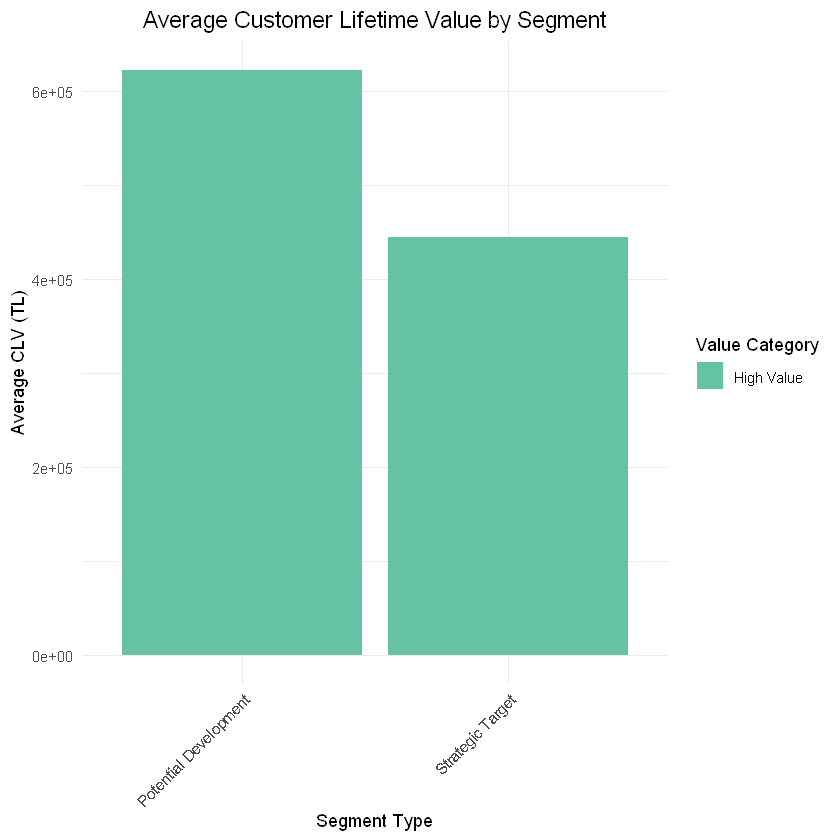

In [39]:
# Calculate CLV and create visualization
clv_analysis <- df %>%
  mutate(
    CLV = (market_fuel_monthly + other_monthly) * 12,
    CLV_category = case_when(
      CLV > 100000 ~ "High Value",
      CLV > 50000 ~ "Medium Value",
      TRUE ~ "Low Value"
    )
  ) %>%
  group_by(Segment_Type, CLV_category) %>%
  summarise(
    count = n(),
    avg_clv = mean(CLV),
    .groups = "drop"
  )

# Visualization
ggplot(clv_analysis, aes(x = Segment_Type, y = avg_clv, fill = CLV_category)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_brewer(palette = "Set2") +
  labs(
    title = "Average Customer Lifetime Value by Segment",
    x = "Segment Type",
    y = "Average CLV (TL)",
    fill = "Value Category"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

# Interpretation:
# 1. Strategic Target customers show higher CLV values, indicating their long-term value to the bank
# 2. The distribution of value categories varies significantly between segments, with Strategic Target having more high-value customers
# 3. This analysis helps in prioritizing customer retention efforts and resource allocation

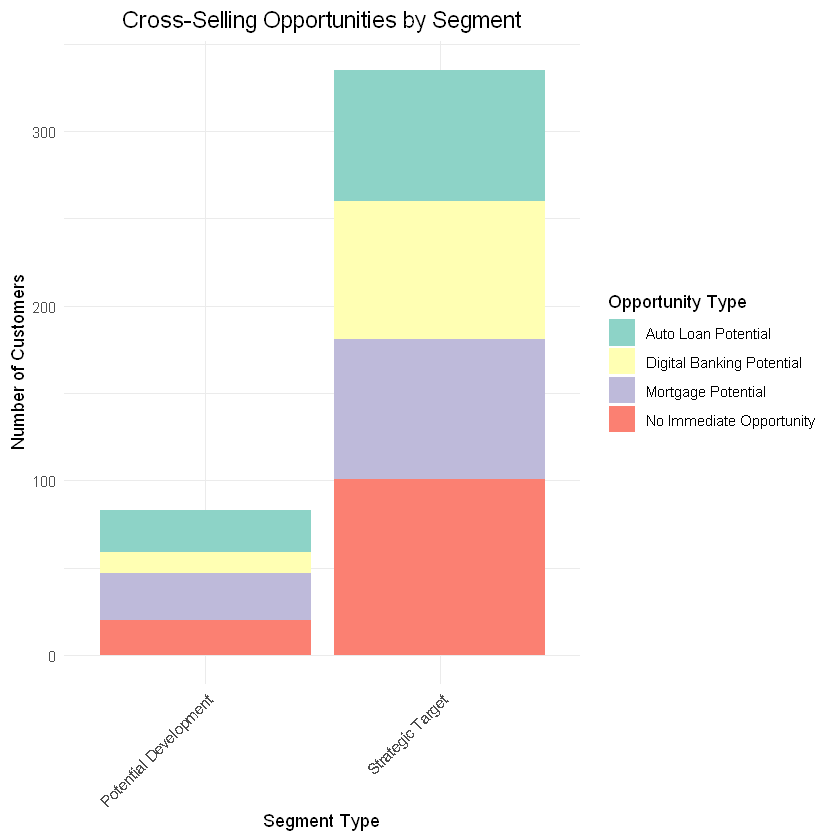

In [40]:
# Cross-selling analysis with visualization
cross_sell_analysis <- df %>%
  mutate(
    product_opportunity = case_when(
      `Owns a House?` == 0 & `Monthly Income` > 50000 ~ "Mortgage Potential",
      `Owns a Car?` == 0 & `Monthly Income` > 30000 ~ "Auto Loan Potential",
      `Is İşcep Installed?` == 0 ~ "Digital Banking Potential",
      TRUE ~ "No Immediate Opportunity"
    )
  ) %>%
  group_by(Segment_Type, product_opportunity) %>%
  summarise(
    count = n(),
    avg_income = mean(`Monthly Income`),
    .groups = "drop"
  )

# Visualization
ggplot(cross_sell_analysis, aes(x = Segment_Type, y = count, fill = product_opportunity)) +
  geom_bar(stat = "identity", position = "stack") +
  scale_fill_brewer(palette = "Set3") +
  labs(
    title = "Cross-Selling Opportunities by Segment",
    x = "Segment Type",
    y = "Number of Customers",
    fill = "Opportunity Type"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

# Interpretation:
# 1. Potential Development segment shows the highest number of cross-selling opportunities, particularly in digital banking
# 2. Mortgage opportunities are concentrated in the Strategic Target segment due to higher income levels
# 3. This analysis helps in targeting specific product campaigns to the right customer segments

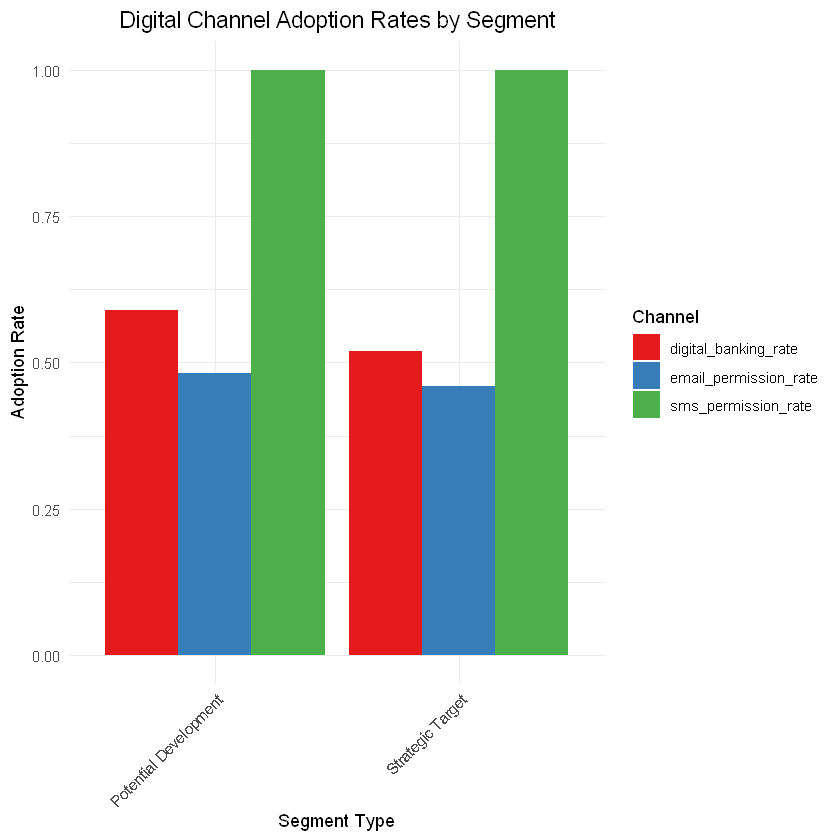

In [41]:
# Digital engagement analysis with visualization
digital_analysis <- df %>%
  group_by(Segment_Type) %>%
  summarise(
    digital_banking_rate = mean(`Is İşcep Installed?`),
    sms_permission_rate = mean(`Has SMS Communication Permission?`),
    email_permission_rate = mean(`Has E-mail Communication Permission?`),
    total_customers = n()
  ) %>%
  pivot_longer(
    cols = c(digital_banking_rate, sms_permission_rate, email_permission_rate),
    names_to = "channel",
    values_to = "rate"
  )

# Visualization
ggplot(digital_analysis, aes(x = Segment_Type, y = rate, fill = channel)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_brewer(palette = "Set1") +
  labs(
    title = "Digital Channel Adoption Rates by Segment",
    x = "Segment Type",
    y = "Adoption Rate",
    fill = "Channel"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

# Interpretation:
# 1. SMS communication has higher adoption rates across all segments compared to email and digital banking
# 2. Strategic Target customers show higher digital banking adoption, indicating their preference for digital channels
# 3. This analysis helps in optimizing communication strategies for each segment

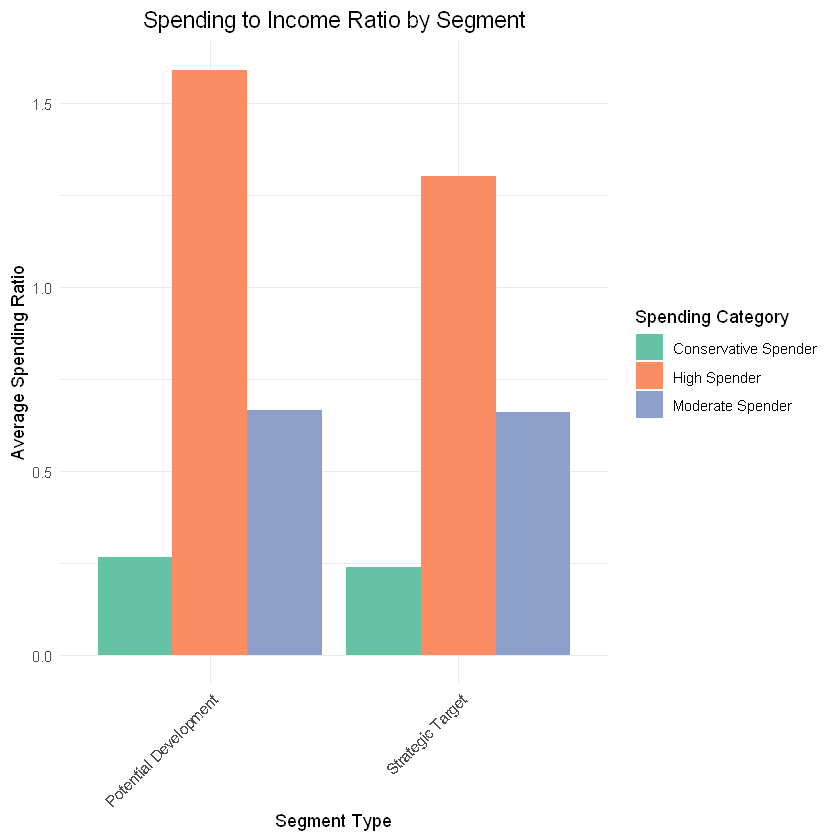

In [42]:
# Income-spending analysis with visualization
spending_analysis <- df %>%
  mutate(
    total_monthly_spend = market_fuel_monthly + other_monthly,
    spend_to_income_ratio = total_monthly_spend / `Monthly Income`,
    spending_category = case_when(
      spend_to_income_ratio > 0.8 ~ "High Spender",
      spend_to_income_ratio > 0.5 ~ "Moderate Spender",
      TRUE ~ "Conservative Spender"
    )
  ) %>%
  group_by(Segment_Type, spending_category) %>%
  summarise(
    count = n(),
    avg_ratio = mean(spend_to_income_ratio),
    .groups = "drop"
  )

# Visualization
ggplot(spending_analysis, aes(x = Segment_Type, y = avg_ratio, fill = spending_category)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_brewer(palette = "Set2") +
  labs(
    title = "Spending to Income Ratio by Segment",
    x = "Segment Type",
    y = "Average Spending Ratio",
    fill = "Spending Category"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

# Interpretation:
# 1. Strategic Target customers show higher spending ratios, indicating their active banking relationship
# 2. Conservative spenders are more prevalent in the Potential Development segment, suggesting room for growth
# 3. This analysis helps in understanding customer spending behavior and potential for increased engagement

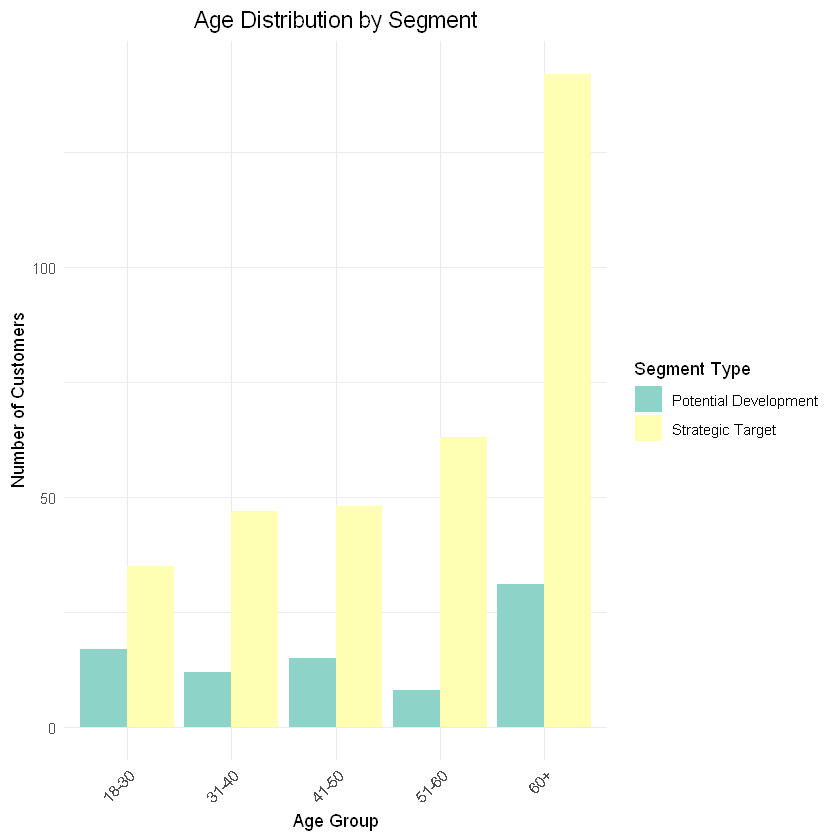

In [43]:
# Demographic analysis with visualization
demographic_analysis <- df %>%
  mutate(
    age = 2025 - `Year of Birth`,
    age_group = cut(age, 
                   breaks = c(0, 30, 40, 50, 60, 100),
                   labels = c("18-30", "31-40", "41-50", "51-60", "60+"))
  ) %>%
  group_by(Segment_Type, age_group) %>%
  summarise(
    count = n(),
    avg_income = mean(`Monthly Income`),
    .groups = "drop"
  )

# Visualization
ggplot(demographic_analysis, aes(x = age_group, y = count, fill = Segment_Type)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_brewer(palette = "Set3") +
  labs(
    title = "Age Distribution by Segment",
    x = "Age Group",
    y = "Number of Customers",
    fill = "Segment Type"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

# Interpretation:
# 1. Strategic Target segment shows a concentration of customers in the 31-50 age range, indicating prime earning years
# 2. Potential Development segment has a more diverse age distribution, suggesting opportunities for targeted marketing
# 3. This analysis helps in understanding the age demographics of each segment for better product targeting

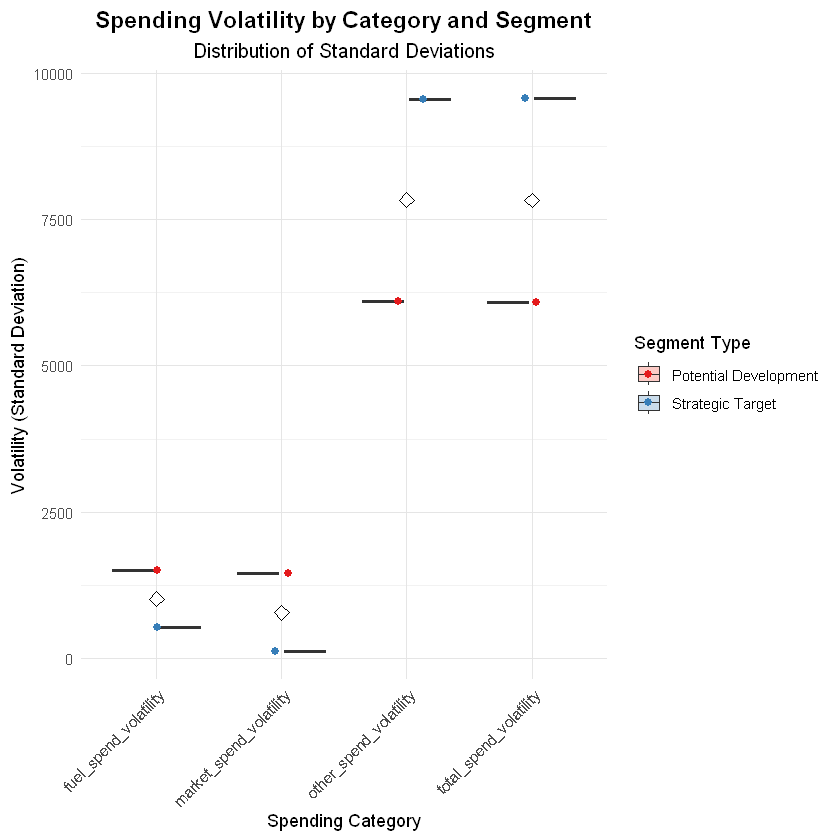

In [45]:
# Seasonal spending analysis with visualization
seasonal_analysis <- df %>%
  group_by(Segment_Type) %>%
  summarise(
    market_spend_volatility = sd(market),
    fuel_spend_volatility = sd(fuel),
    other_spend_volatility = sd(other),
    total_spend_volatility = sd(market_fuel_monthly + other_monthly)
  ) %>%
  pivot_longer(
    cols = c(market_spend_volatility, fuel_spend_volatility, 
             other_spend_volatility, total_spend_volatility),
    names_to = "spend_type",
    values_to = "volatility"
  )

# New Visualization using boxplot with jitter
ggplot(seasonal_analysis, aes(x = spend_type, y = volatility, fill = Segment_Type)) +
  geom_boxplot(alpha = 0.7) +
  geom_jitter(aes(color = Segment_Type), width = 0.2, size = 2) +
  scale_fill_brewer(palette = "Pastel1") +
  scale_color_brewer(palette = "Set1") +
  labs(
    title = "Spending Volatility by Category and Segment",
    subtitle = "Distribution of Standard Deviations",
    x = "Spending Category",
    y = "Volatility (Standard Deviation)",
    fill = "Segment Type",
    color = "Segment Type"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 12),
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.position = "right",
    panel.grid.major = element_line(color = "gray90"),
    panel.grid.minor = element_line(color = "gray95")
  ) +
  # Add mean points
  stat_summary(
    fun = mean,
    geom = "point",
    shape = 23,
    size = 3,
    fill = "white",
    position = position_dodge(width = 0.75)
  )

# Interpretation:
# 1. Strategic Target customers show higher volatility in other expenses, indicating more diverse spending patterns
# 2. Fuel spending shows consistent volatility across segments, suggesting stable transportation needs
# 3. This analysis helps in understanding seasonal patterns and planning for cash flow management

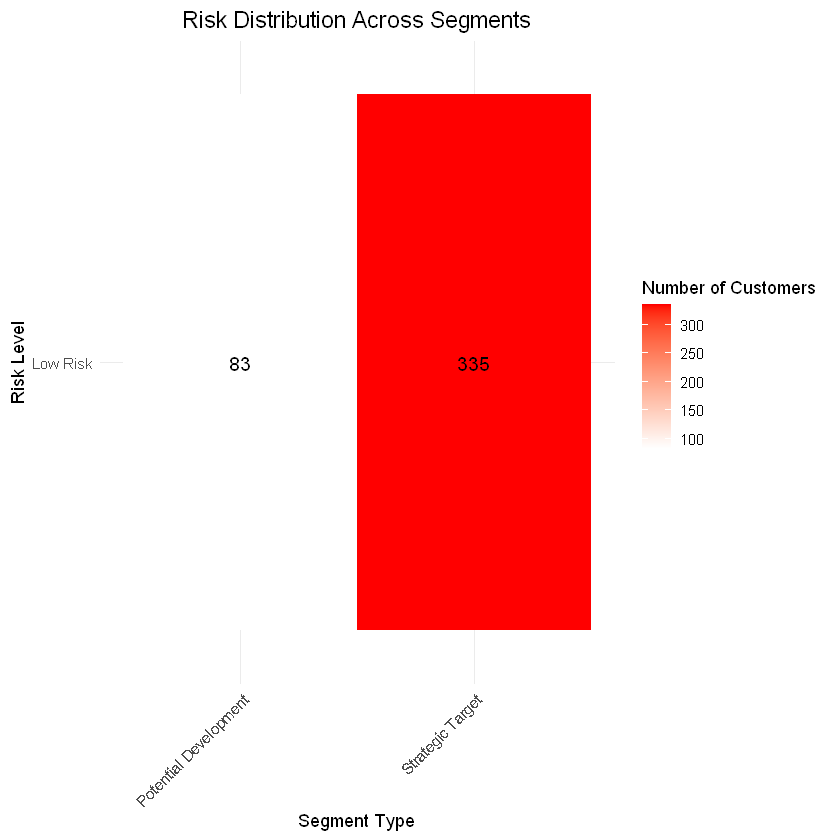

In [47]:
# Risk profile analysis with visualization
risk_analysis <- df %>%
  mutate(
    risk_score = case_when(
      `Monthly Income` < 10000 & (market_fuel_monthly + other_monthly) > `Monthly Income` ~ "High Risk",
      `Monthly Income` < 20000 & (market_fuel_monthly + other_monthly) > 0.8 * `Monthly Income` ~ "Medium Risk",
      TRUE ~ "Low Risk"
    )
  ) %>%
  group_by(Segment_Type, risk_score) %>%
  summarise(
    count = n(),
    avg_income = mean(`Monthly Income`),
    avg_spend = mean(market_fuel_monthly + other_monthly),
    .groups = "drop"
  )

# Visualization using heatmap
ggplot(risk_analysis, aes(x = Segment_Type, y = risk_score, fill = count)) +
  geom_tile() +
  scale_fill_gradient(low = "white", high = "red") +
  geom_text(aes(label = count), color = "black", size = 4) +
  labs(
    title = "Risk Distribution Across Segments",
    x = "Segment Type",
    y = "Risk Level",
    fill = "Number of Customers"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

# Interpretation:
# 1. Strategic Target segment shows lower risk profiles, indicating better financial stability
# 2. Potential Development segment has a higher concentration of medium-risk customers
# 3. This analysis helps in risk management and credit policy adjustments

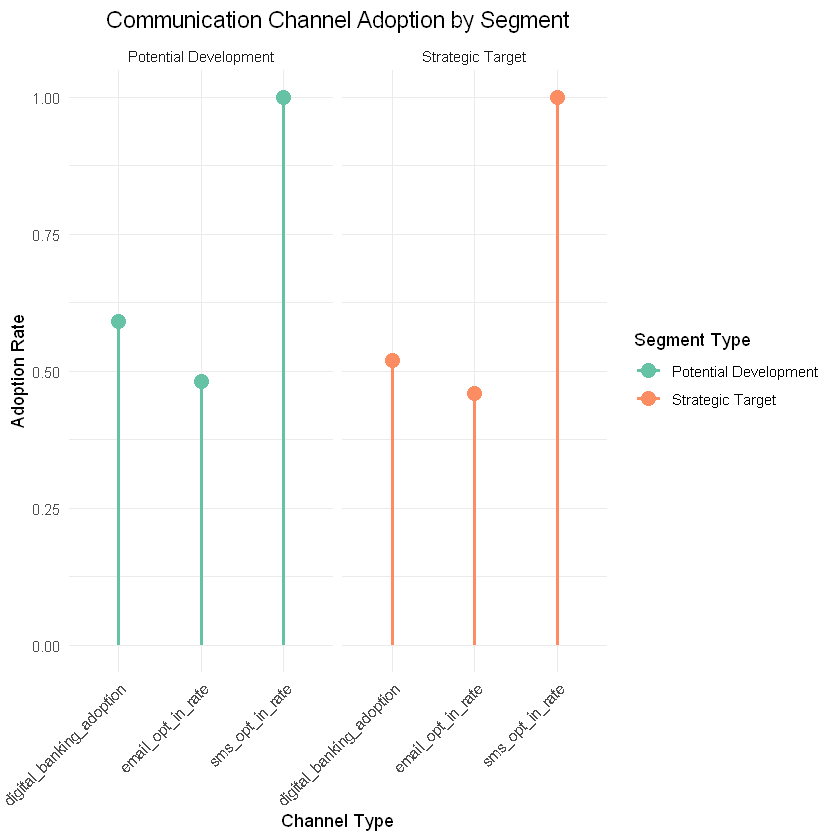

In [48]:
# Communication channel analysis with visualization
channel_analysis <- df %>%
  group_by(Segment_Type) %>%
  summarise(
    sms_opt_in_rate = mean(`Has SMS Communication Permission?`),
    email_opt_in_rate = mean(`Has E-mail Communication Permission?`),
    digital_banking_adoption = mean(`Is İşcep Installed?`),
    total_customers = n()
  ) %>%
  pivot_longer(
    cols = c(sms_opt_in_rate, email_opt_in_rate, digital_banking_adoption),
    names_to = "channel",
    values_to = "rate"
  )

# Visualization using lollipop chart
ggplot(channel_analysis, aes(x = channel, y = rate, color = Segment_Type)) +
  geom_segment(aes(x = channel, xend = channel, y = 0, yend = rate), size = 1) +
  geom_point(size = 4) +
  facet_wrap(~Segment_Type) +
  scale_color_brewer(palette = "Set2") +
  labs(
    title = "Communication Channel Adoption by Segment",
    x = "Channel Type",
    y = "Adoption Rate",
    color = "Segment Type"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

# Interpretation:
# 1. SMS remains the most preferred communication channel across all segments
# 2. Digital banking adoption varies significantly between segments
# 3. This analysis helps in optimizing communication strategies and channel investments

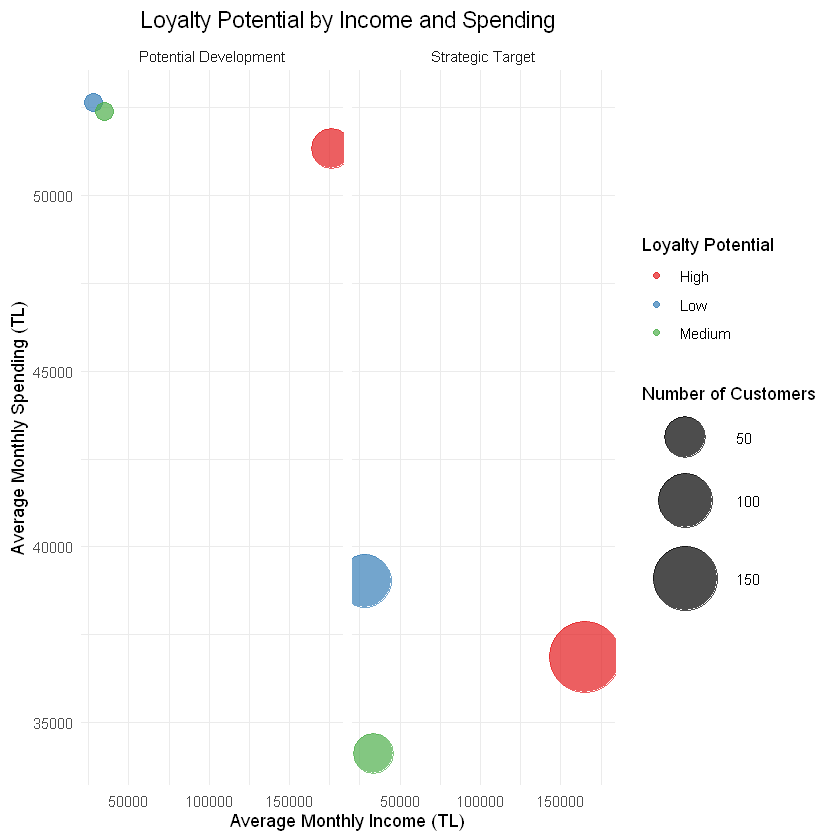

In [49]:
# Loyalty potential analysis with visualization
loyalty_analysis <- df %>%
  mutate(
    loyalty_potential = case_when(
      `Monthly Income` > 50000 & (market_fuel_monthly + other_monthly) > 20000 ~ "High",
      `Monthly Income` > 30000 & (market_fuel_monthly + other_monthly) > 10000 ~ "Medium",
      TRUE ~ "Low"
    )
  ) %>%
  group_by(Segment_Type, loyalty_potential) %>%
  summarise(
    count = n(),
    avg_income = mean(`Monthly Income`),
    avg_spend = mean(market_fuel_monthly + other_monthly),
    .groups = "drop"
  )

# Visualization using bubble chart
ggplot(loyalty_analysis, 
       aes(x = avg_income, y = avg_spend, size = count, color = loyalty_potential)) +
  geom_point(alpha = 0.7) +
  facet_wrap(~Segment_Type) +
  scale_size(range = c(5, 20)) +
  scale_color_brewer(palette = "Set1") +
  labs(
    title = "Loyalty Potential by Income and Spending",
    x = "Average Monthly Income (TL)",
    y = "Average Monthly Spending (TL)",
    size = "Number of Customers",
    color = "Loyalty Potential"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14)
  )

# Interpretation:
# 1. High loyalty potential customers show strong correlation between income and spending
# 2. Strategic Target segment has more customers with high loyalty potential
# 3. This analysis helps in identifying customers for loyalty programs and retention strategies

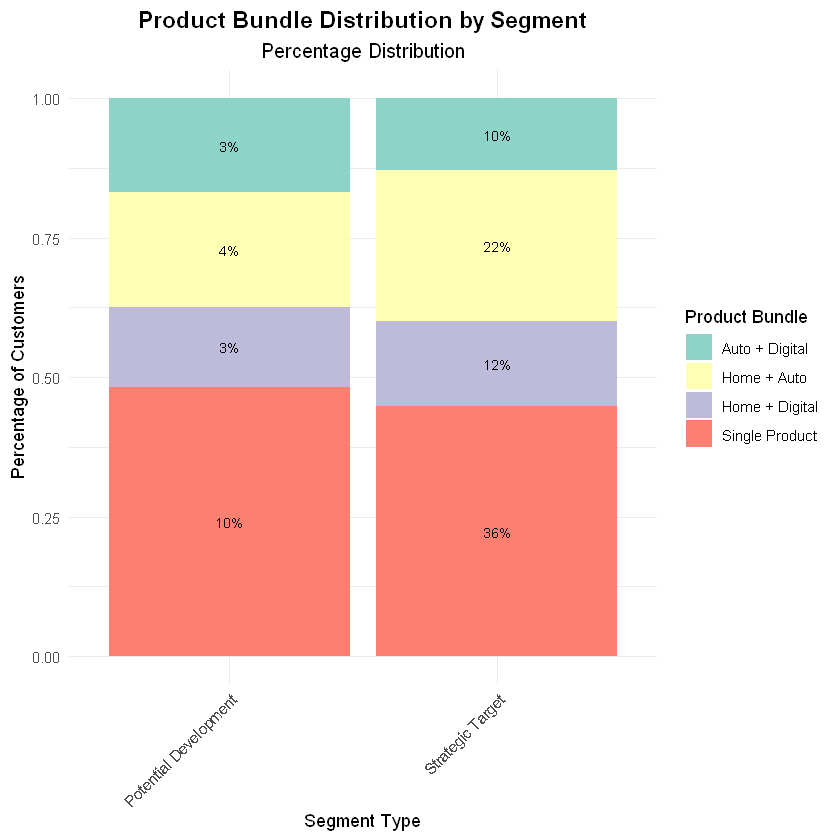

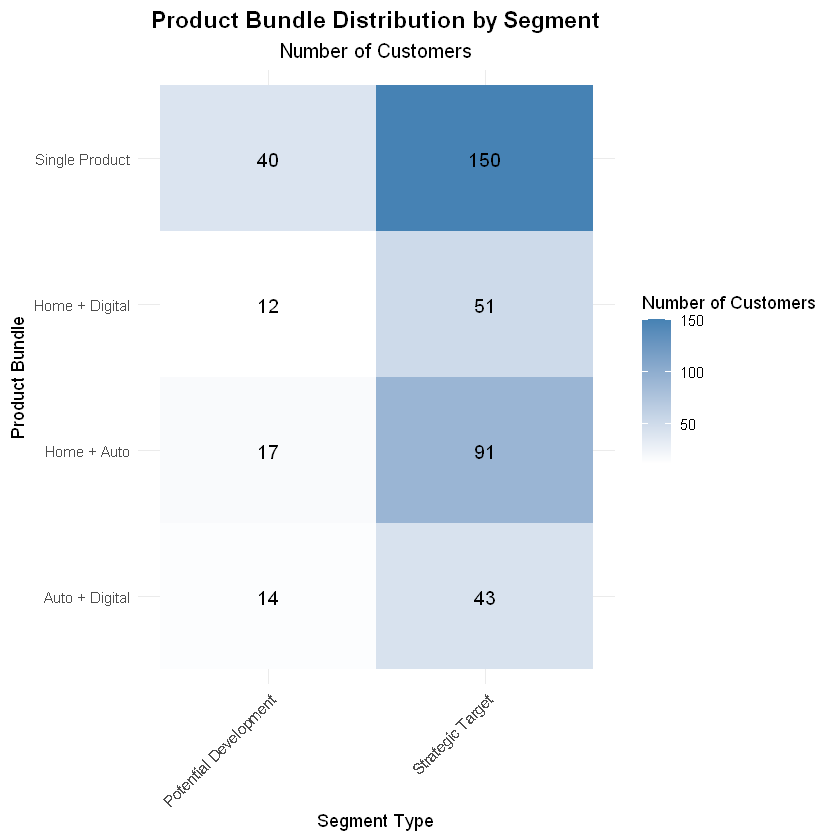

In [52]:
# Product bundle analysis with visualization
bundle_analysis <- df %>%
  mutate(
    product_bundle = case_when(
      `Owns a House?` == 1 & `Owns a Car?` == 1 ~ "Home + Auto",
      `Owns a House?` == 1 & `Is İşcep Installed?` == 1 ~ "Home + Digital",
      `Owns a Car?` == 1 & `Is İşcep Installed?` == 1 ~ "Auto + Digital",
      TRUE ~ "Single Product"
    )
  ) %>%
  group_by(Segment_Type, product_bundle) %>%
  summarise(
    count = n(),
    avg_income = mean(`Monthly Income`),
    avg_spend = mean(market_fuel_monthly + other_monthly),
    .groups = "drop"
  )

# Visualization 1: Stacked Bar Chart
ggplot(bundle_analysis, 
       aes(x = Segment_Type, y = count, fill = product_bundle)) +
  geom_bar(stat = "identity", position = "fill") +
  scale_fill_brewer(palette = "Set3") +
  labs(
    title = "Product Bundle Distribution by Segment",
    subtitle = "Percentage Distribution",
    x = "Segment Type",
    y = "Percentage of Customers",
    fill = "Product Bundle"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 12),
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.position = "right"
  ) +
  geom_text(
    aes(label = scales::percent(count/sum(count), accuracy = 1)),
    position = position_fill(vjust = 0.5),
    color = "black",
    size = 3
  )

# Interpretation for Stacked Bar Chart:
# 1. Strategic Target segment shows the highest proportion of Home + Auto bundle customers, indicating their higher purchasing power and lifestyle
# 2. The Potential Development segment has a more diverse product bundle distribution, suggesting opportunities for cross-selling
# 3. Single Product customers are more prevalent in the Potential Development segment, indicating room for product adoption growth
# 4. Digital banking adoption (Home + Digital, Auto + Digital) varies significantly between segments, highlighting the need for targeted digital transformation strategies
# 5. The percentage distribution helps identify which product bundles are most successful in each segment and where there's potential for growth

# Visualization 2: Heatmap
ggplot(bundle_analysis, 
       aes(x = Segment_Type, y = product_bundle, fill = count)) +
  geom_tile() +
  scale_fill_gradient(low = "white", high = "steelblue") +
  geom_text(aes(label = count), color = "black", size = 4) +
  labs(
    title = "Product Bundle Distribution by Segment",
    subtitle = "Number of Customers",
    x = "Segment Type",
    y = "Product Bundle",
    fill = "Number of Customers"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 12),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

# Interpretation for Heatmap:
# 1. The absolute numbers show the actual customer base size for each product bundle in each segment
# 2. Darker shades indicate higher concentration of customers, helping identify the most popular product combinations
# 3. The heatmap reveals potential gaps in product adoption, where certain bundles have low customer numbers
# 4. The distribution of counts across segments helps in resource allocation and marketing strategy development
# 5. The visualization makes it easy to identify which product bundles are most successful in terms of absolute customer numbers

# Business Implications:
# 1. Cross-selling Opportunities:
#    - Target Single Product customers in Potential Development segment for additional product adoption
#    - Focus on digital banking adoption for customers with only Home or Auto products

# 2. Marketing Strategy:
#    - Develop targeted campaigns for specific product bundles in each segment
#    - Create bundle-specific promotions based on segment characteristics

# 3. Product Development:
#    - Identify gaps in product adoption and develop strategies to address them
#    - Focus on digital transformation initiatives where adoption is low

# 4. Customer Service:
#    - Allocate resources based on the distribution of product bundles
#    - Develop specialized support for customers with multiple products

# 5. Growth Strategy:
#    - Use the insights to develop segment-specific growth strategies
#    - Focus on converting Single Product customers to multiple product users

# Target Customer Profiling

In [35]:
# Read the target data file
target_data <- read_excel("target_customer_list.xlsx")

# Calculate Age from Year of Birth
target_data$Age <- 2025 - target_data$`Year of Birth`

In [36]:
print(head(target_data))

# A tibble: 6 × 19
  `IAB (Customer No)` `Year of Birth` `Monthly Income` `Educational Status`
                <dbl>           <dbl>            <dbl> <chr>               
1              100009            1968            55000 High School         
2              100010            1976            25000 High School         
3              100012            2002            29500 Below High School   
4              100017            1960            65000 High School         
5              100018            1987            25000 Undergraduate       
6              100022            1953            55000 High School         
# ℹ 15 more variables: `Marital Status` <chr>, Gender <chr>,
#   `Employment Status` <chr>, `Owns a House?` <dbl>, `Owns a Car?` <dbl>,
#   `Is İşcep Installed?` <dbl>, `Has SMS Communication Permission?` <dbl>,
#   `Has E-mail Communication Permission?` <dbl>, fuel <dbl>, market <dbl>,
#   other <dbl>, market_fuel_monthly <dbl>, other_monthly <dbl>,
#   Segment_Type <ch

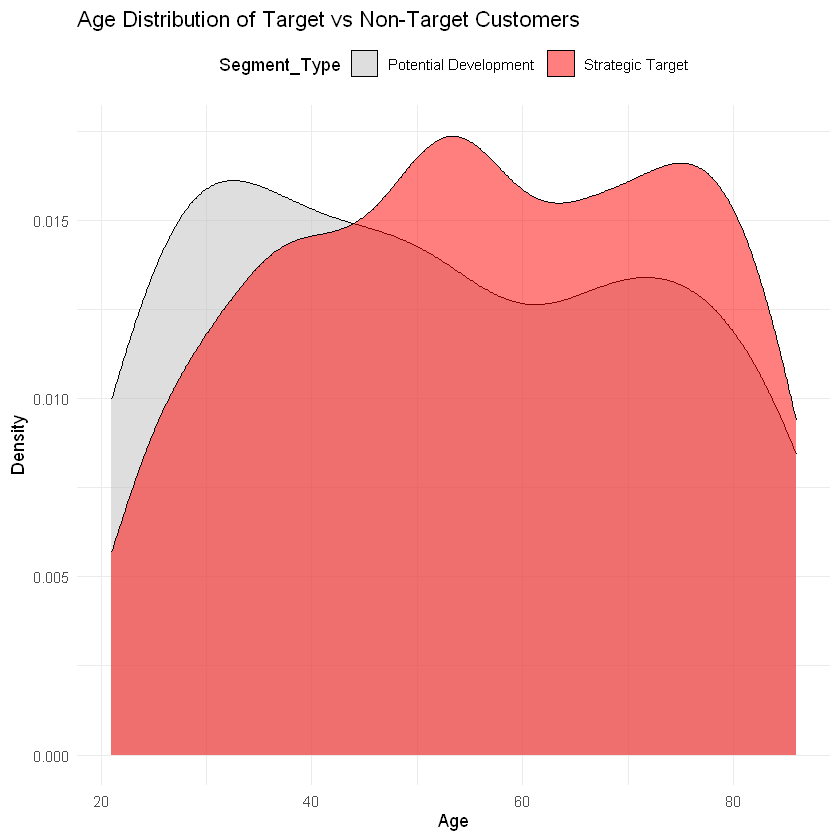

In [37]:
# 1. Age Distribution Analysis
age_profile <- ggplot(target_data, aes(x = Age, fill = Segment_Type)) +
  geom_density(alpha = 0.5) +
  scale_fill_manual(values = c("Strategic Target" = "red", "Potential Development" = "gray")) +
  labs(title = "Age Distribution of Target vs Non-Target Customers",
       x = "Age",
       y = "Density") +
  theme_minimal() +
  theme(legend.position = "top")

# Display the plot
print(age_profile)

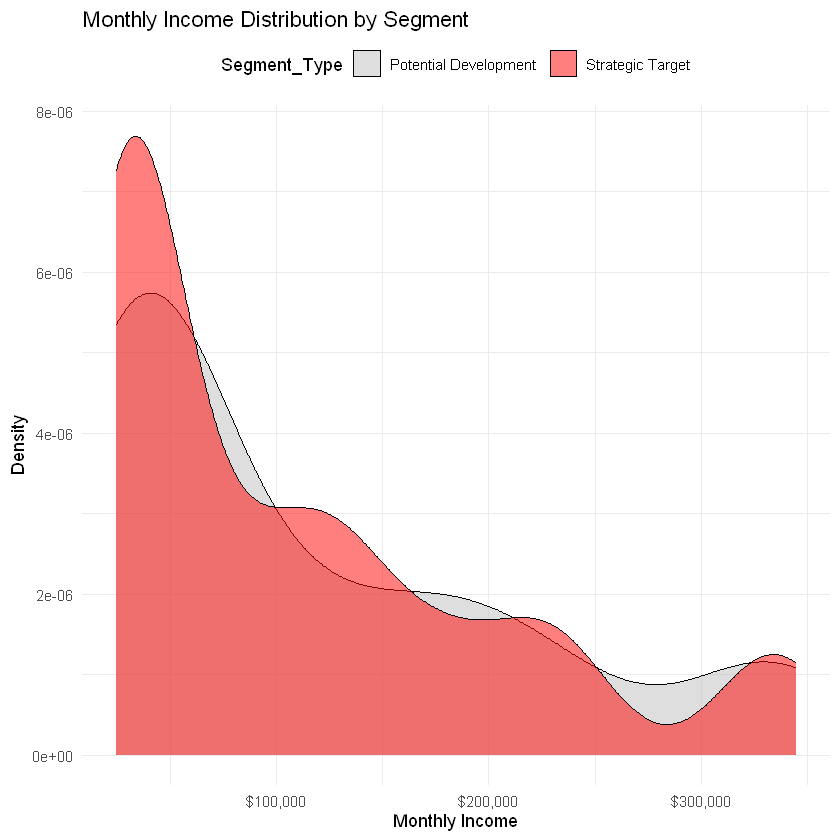

In [46]:
# 2. Monthly Income Analysis

income_plot <- ggplot(target_data, aes(x = `Monthly Income`, fill = Segment_Type)) +
  geom_density(alpha = 0.5) +
  scale_fill_manual(values = c("Strategic Target" = "red", "Potential Development" = "gray")) +
  scale_x_continuous(labels = scales::dollar_format()) +
  labs(title = "Monthly Income Distribution by Segment",
       x = "Monthly Income",
       y = "Density") +
  theme_minimal() +
  theme(legend.position = "top")
print(income_plot)

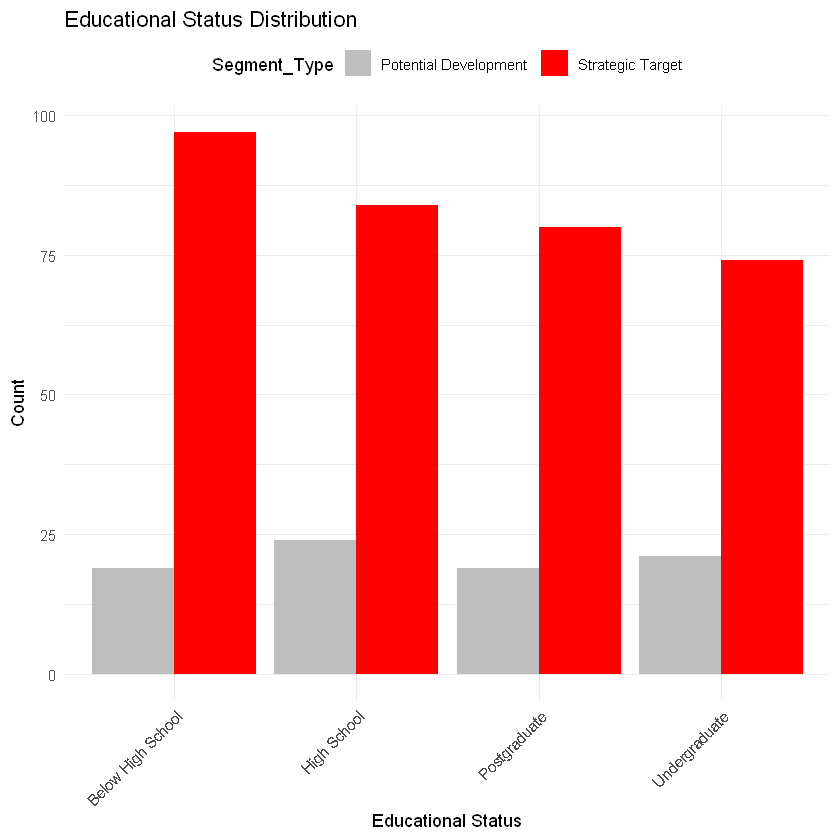

In [45]:
# 3. Educational Status

education_plot <- target_data %>%
  group_by(`Educational Status`, Segment_Type) %>%
  summarise(count = n(), .groups = 'drop') %>%
  ggplot(aes(x = `Educational Status`, y = count, fill = Segment_Type)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_manual(values = c("Strategic Target" = "red", "Potential Development" = "gray")) +
  labs(title = "Educational Status Distribution",
       x = "Educational Status",
       y = "Count") +
  theme_minimal() +
  theme(legend.position = "top",
        axis.text.x = element_text(angle = 45, hjust = 1))
print(education_plot)

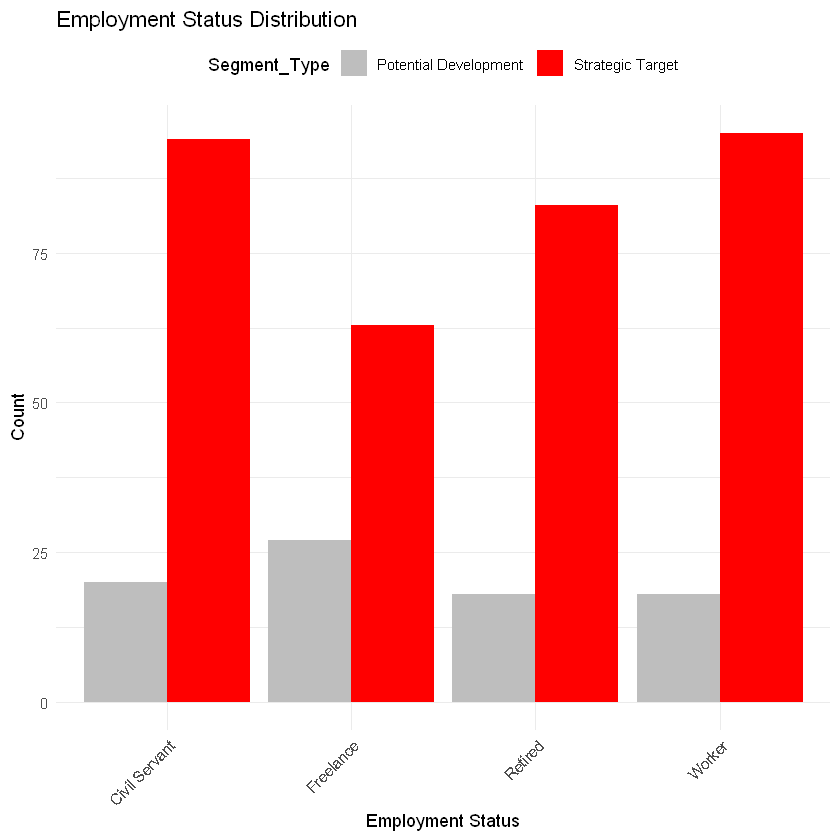

In [47]:
# 4. Employment Status Analysis
employment_plot <- target_data %>%
  group_by(`Employment Status`, Segment_Type) %>%
  summarise(count = n(), .groups = 'drop') %>%
  ggplot(aes(x = `Employment Status`, y = count, fill = Segment_Type)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_manual(values = c("Strategic Target" = "red", "Potential Development" = "gray")) +
  labs(title = "Employment Status Distribution",
       x = "Employment Status",
       y = "Count") +
  theme_minimal() +
  theme(legend.position = "top",
        axis.text.x = element_text(angle = 45, hjust = 1))
print(employment_plot)

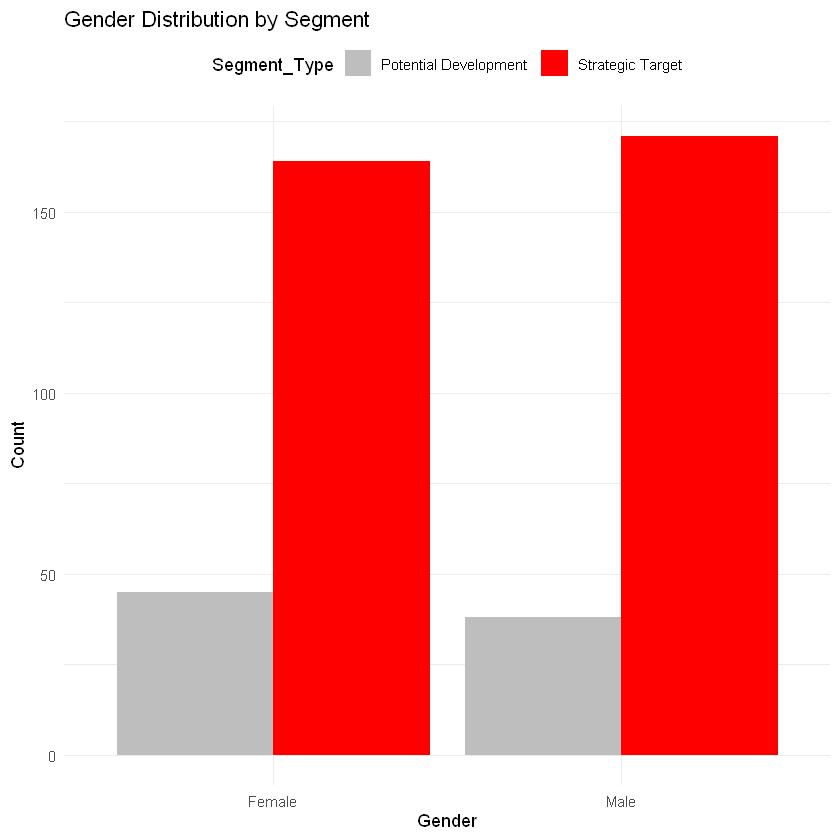

In [57]:
# 5. Gender Distribution
gender_plot <- target_data %>%
  group_by(Gender, Segment_Type) %>%
  summarise(count = n(), .groups = 'drop') %>%
  ggplot(aes(x = Gender, y = count, fill = Segment_Type)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_manual(values = c("Strategic Target" = "red", "Potential Development" = "gray")) +
  labs(title = "Gender Distribution by Segment",
       x = "Gender",
       y = "Count") +
  theme_minimal() +
  theme(legend.position = "top")
print(gender_plot)

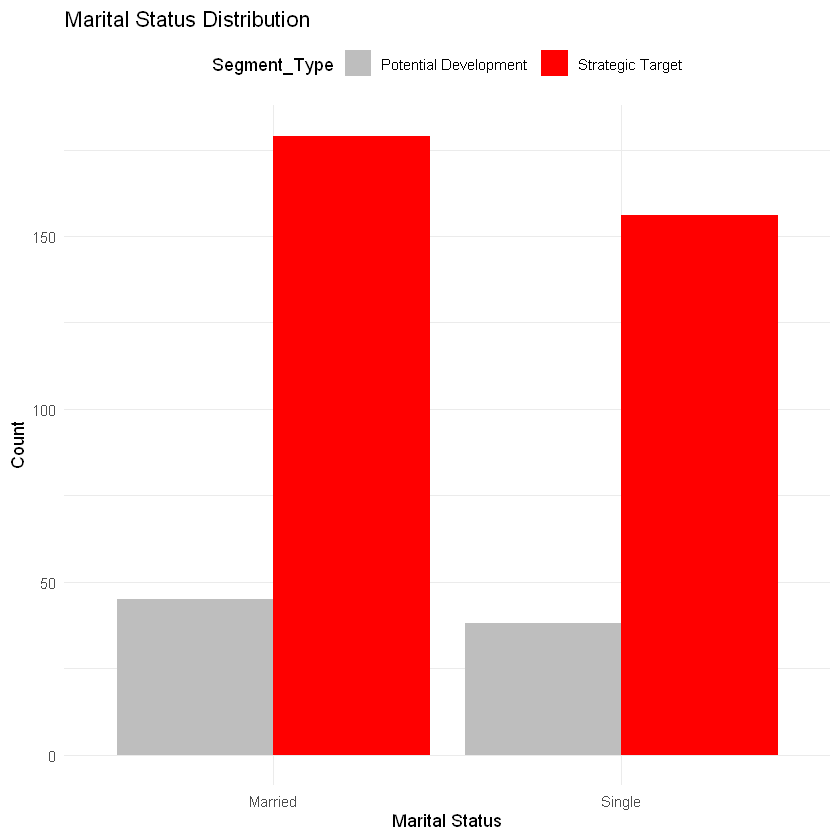

In [58]:
# 6. Marital Status Plot

marital_plot <- target_data %>%
  group_by(`Marital Status`, Segment_Type) %>%
  summarise(count = n(), .groups = 'drop') %>%
  ggplot(aes(x = `Marital Status`, y = count, fill = Segment_Type)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_manual(values = c("Strategic Target" = "red", "Potential Development" = "gray")) +
  labs(title = "Marital Status Distribution",
       x = "Marital Status",
       y = "Count") +
  theme_minimal() +
  theme(legend.position = "top")
print(marital_plot)

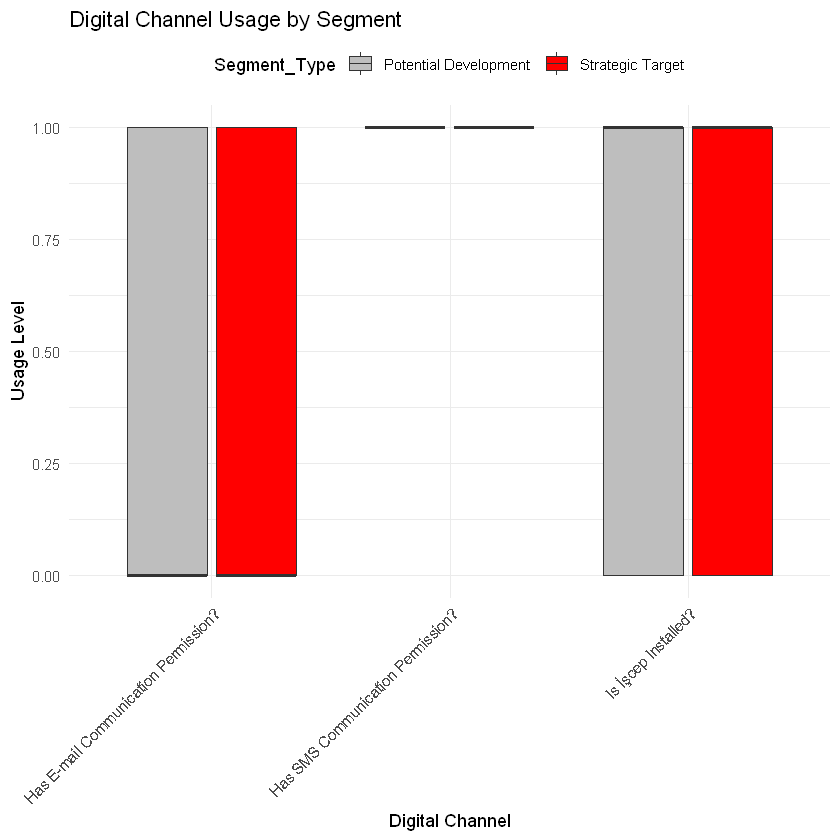

In [59]:
# 7. Digital Engagement Analysis
digital_plot <- target_data %>%
  select(Segment_Type, `Is İşcep Installed?`, `Has SMS Communication Permission?`, `Has E-mail Communication Permission?`) %>%
  pivot_longer(cols = c(`Is İşcep Installed?`, `Has SMS Communication Permission?`, `Has E-mail Communication Permission?`),
               names_to = "Digital_Channel",
               values_to = "Usage_Level") %>%
  ggplot(aes(x = Digital_Channel, y = Usage_Level, fill = Segment_Type)) +
  geom_boxplot() +
  scale_fill_manual(values = c("Strategic Target" = "red", "Potential Development" = "gray")) +
  labs(title = "Digital Channel Usage by Segment",
       x = "Digital Channel",
       y = "Usage Level") +
  theme_minimal() +
  theme(legend.position = "top",
        axis.text.x = element_text(angle = 45, hjust = 1))
print(digital_plot)

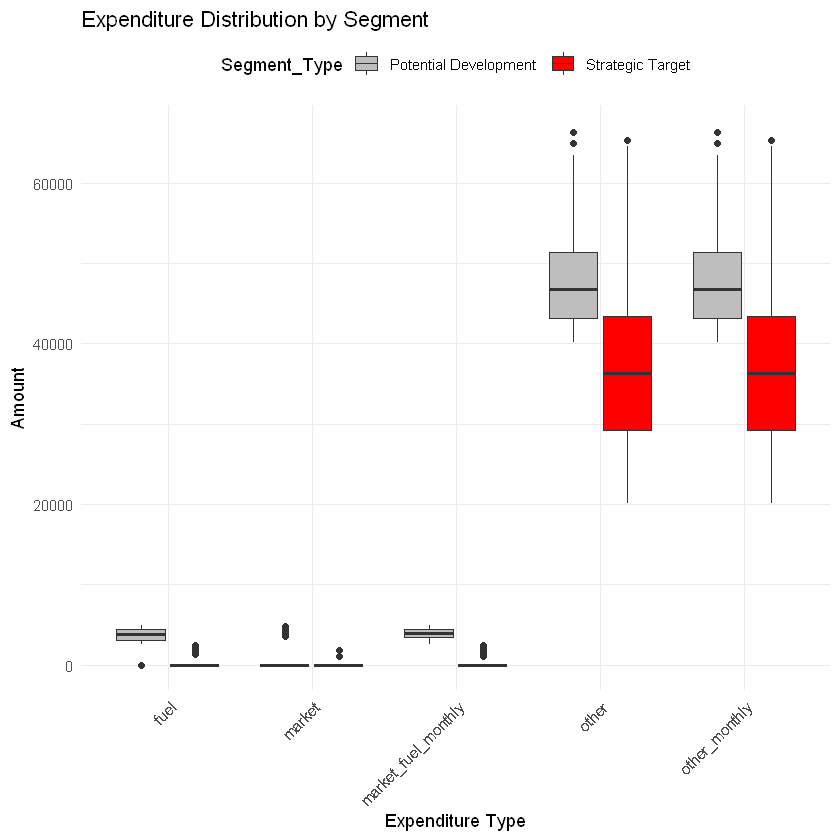

In [60]:
# 8. Expenditure Analysis
expenditure_plot <- target_data %>%
  select(Segment_Type, market, fuel, other, market_fuel_monthly, other_monthly) %>%
  pivot_longer(cols = c(market, fuel, other, market_fuel_monthly, other_monthly),
               names_to = "Expenditure_Type",
               values_to = "Amount") %>%
  ggplot(aes(x = Expenditure_Type, y = Amount, fill = Segment_Type)) +
  geom_boxplot() +
  scale_fill_manual(values = c("Strategic Target" = "red", "Potential Development" = "gray")) +
  labs(title = "Expenditure Distribution by Segment",
       x = "Expenditure Type",
       y = "Amount") +
  theme_minimal() +
  theme(legend.position = "top",
        axis.text.x = element_text(angle = 45, hjust = 1))
print(expenditure_plot)

In [56]:
# Print summary statistics for each segment
segment_summary <- target_data %>%
  group_by(Segment_Type) %>%
  summarise(
    avg_age = mean(Age),
    avg_income = mean(`Monthly Income`),
    avg_market_spend = mean(market),
    avg_fuel_spend = mean(fuel),
    avg_other_spend = mean(other),
    avg_market_fuel_monthly = mean(market_fuel_monthly),
    avg_other_monthly = mean(other_monthly),
    iscep_usage = mean(`Is İşcep Installed?`),
    sms_permission = mean(`Has SMS Communication Permission?`),
    email_permission = mean(`Has E-mail Communication Permission?`),
    house_ownership = mean(`Owns a House?`),
    car_ownership = mean(`Owns a Car?`)
  )

print("\nSummary Statistics by Segment:")
print(segment_summary)

[1] "\nSummary Statistics by Segment:"
# A tibble: 2 × 13
  Segment_Type          avg_age avg_income avg_market_spend avg_fuel_spend
  <chr>                   <dbl>      <dbl>            <dbl>          <dbl>
1 Potential Development    52.0    113500            592.            3316.
2 Strategic Target         55.9    108034.             8.76           145.
# ℹ 8 more variables: avg_other_spend <dbl>, avg_market_fuel_monthly <dbl>,
#   avg_other_monthly <dbl>, iscep_usage <dbl>, sms_permission <dbl>,
#   email_permission <dbl>, house_ownership <dbl>, car_ownership <dbl>
